# Практическое задание по теме 6. Данные в страховом бизнесе. 
## EDA

In [1]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Задание
На основе датасета из ноутбука проведите анализ данных и постройте зависимости частоты и среднего убытка от какого-либо параметра (за исключением уже выполненных в ноутбуке).

### 1. Обзор обучающего датасета <a name = 'data'></a>

#### Описание датасета

* __Exposure__ - выраженный в годах срок действия договора страхования в отчетном периоде (0.001 - 1)
* __LicAge__ - водительский стаж
* __RecordBeg__ - дата начала действия страхового договора - текущий год
* __RecordEnd__ - дата окончания действия страхового договора в текущем году
* __VehAge__ - возраст транспортного средства
* __Gender__ - пол водителя
* __MariStat__ - семейное положение
* __SocioCateg__ - социальная категория
* __VehUsage__ - использование транспортного средства (в частных целях, в частных целях плюс поездки до офиса, профессиональное использование, профессиональные перевозки)
* __DrivAge__ - возраст водителя
* __HasKmLimit__ - наличие/отстутсвие лимита по киллометражу
* __BonusMalus__ - бонусные баллы от 50 до 272
* __VehBody__ - тип транспотного средства (седан, кабриолет, автобус, микроавтобус и т.д)
* __VehPrice__ - код цены транспортного средства
* __VehEngine__ - тип двигателя (электрический, карбюраторный, инжекторный, газовый и т.д.)
* __VehEnergy__ - тип топлива транспортного средства (обычное, дизельное, электрическое, газовое)
* __VehMaxSpeed__ - максимальная скорость транспортного средства
* __VehClass__ - код класса транспортного средства
* __ClaimAmount__ - сумма страховго возмещения
* __RiskVar__ - оценка риска по 20-балльной шкале
* __Garage__ - отсутсвие гаража, частный гараж, коллективный гараж
* __ClaimInd__ - наличие/ отсутствие страховых случаев
* __Dataset__ - индекс датасета (1-10)
* __DeducType__ - тип скидки 
* __ClaimNbResp__ - оценка ClaimNbResp по 5-балльной шкале (0-5)
* __ClaimNbNonResp__ - оценка ClaimNbNonResp по 7-балльной шкале (0-7)
* __ClaimNbParking__ - оценка ClaimNbParking (парковка) по 5-балльной шкале (0-5)
* __ClaimNbFireTheft__ оценка ClaimNbFireTheft (пожар, воровство) по 4-балльной шкале (0-4)
* __ClaimNbWindscreen__ оценка ClaimNbWindscreen (ветровое стекло) по 8-балльной шкале (0-8)
* __OutUseNb__ оценка OutUseNb по 5-балльной шкале (0-5)
* __RiskArea__ - оценка RiskArea по 13-балльной шкале (1-13)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_in_business/Lesson_6/'
TRAIN_DATASET_PATH = PATH + 'freMPL-R.csv'

### 2. Загрузка данных <a name = 'load_data'></a>

In [4]:
data = pd.read_csv(TRAIN_DATASET_PATH, parse_dates=[2, 3])
print(data.shape)
data.head(2)

(343080, 31)


,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaT,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaT,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Не разбирать:

In [5]:
ANALYSED_FEATURE_NAMES = ['LicAge', 'Gender', 'MariStat', 'SocioCateg', 'DrivAge']

In [6]:
FEATURE_NAMES = []
for name in data.columns:
    if not name in ANALYSED_FEATURE_NAMES:
        FEATURE_NAMES.append(name)

### 3. Пропуски данных

In [7]:
len(data[FEATURE_NAMES]) - data[FEATURE_NAMES].count()

Exposure                  0
RecordBeg                 0
RecordEnd            161965
VehAge               165200
VehUsage                  0
HasKmLimit                0
BonusMalus                0
VehBody              197300
VehPrice             197300
VehEngine            197300
VehEnergy            197300
VehMaxSpeed          197300
VehClass             197300
ClaimAmount               0
RiskVar              197300
Garage               197300
ClaimInd                  0
Dataset                   0
DeducType            276190
ClaimNbResp          145780
ClaimNbNonResp       145780
ClaimNbParking       145780
ClaimNbFireTheft     145780
ClaimNbWindscreen    145780
OutUseNb             145780
RiskArea             145780
dtype: int64

### 2. Классификация признаков

In [8]:
df = data.copy()
df['PolicyCount'] = 1
df['ClaimCount'] = df['ClaimAmount'] > 0
df['NoClaimCount'] = df.PolicyCount - df.ClaimCount
df[['PolicyCount','ClaimAmount', 'ClaimCount', 'NoClaimCount']].head(2)

,PolicyCount,ClaimAmount,ClaimCount,NoClaimCount
0,1,0.0,False,1
1,1,0.0,False,1


In [9]:
def plot_dependencies(df, var_name, levels=None): 
    fig, axes = plt.subplots(4, 1, figsize=(20, 22))
    
    df_group_var = df[['Exposure', 'PolicyCount','ClaimAmount', 'ClaimCount', 'NoClaimCount']].groupby(df[var_name]).sum()
    df_group_var = df_group_var.reset_index()

    df_group_var['Freq'] = df_group_var.ClaimCount / df_group_var.Exposure
    df_group_var['AvgClaim'] = df_group_var.ClaimAmount / df_group_var.ClaimCount 
    
    if levels:
        x=levels
    else:
        x=df_group_var[var_name]
        
    sns.barplot(x=x, y=df_group_var['PolicyCount'], palette="viridis", ax=axes[0])
    sns.barplot(x=x, y=df_group_var['NoClaimCount'], palette="viridis", ax=axes[1])
    sns.barplot(x=x, y=df_group_var['ClaimCount'], color='fuchsia', ax=axes[1])           
    sns.barplot(x=x, y=df_group_var['Freq'], palette="viridis", ax=axes[2])
    sns.barplot(x=x, y=df_group_var['AvgClaim'], palette="viridis", ax=axes[3])    
        
    fig.suptitle(f'Анализ признака {var_name}', fontsize=18)
    axes[0].set_title(f'Распределение числа полисов по {var_name}', size=14)
    axes[1].set_title(f'Распределение числа полисов с убытками и без убытков по {var_name}', size=14)
    axes[2].set_title(f'Зависимость частоты убытков от {var_name}', size=14)
    axes[3].set_title(f'Зависимость среднего убытка от {var_name}', size=14)
    print('\n')
    plt.show()
    print('\n')

### 2. 1. Признаки, связанные со временем

In [10]:
TIME_FEATURE_NAMES = data[FEATURE_NAMES].select_dtypes(include=[np.datetime64]).columns.to_list()
data[TIME_FEATURE_NAMES].head()

,RecordBeg,RecordEnd
0,2004-06-01,NaT
1,2004-10-19,NaT
2,2004-07-16,2004-08-16
3,2004-08-16,NaT
4,2004-01-01,2004-07-01


### 2.2 Количественные признаки

In [11]:
NUMERICAL_FEATURE_NAMES = data[FEATURE_NAMES].select_dtypes(include=[np.number]).columns.to_list()

#### 1. Дискретные признаки

In [12]:
DISCRETE_FEATURE_NAMES = [feature for feature in NUMERICAL_FEATURE_NAMES
                          if len(data[feature].unique()) < 25]

data[DISCRETE_FEATURE_NAMES].head(2)

,HasKmLimit,RiskVar,ClaimInd,Dataset,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0,15.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,20.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


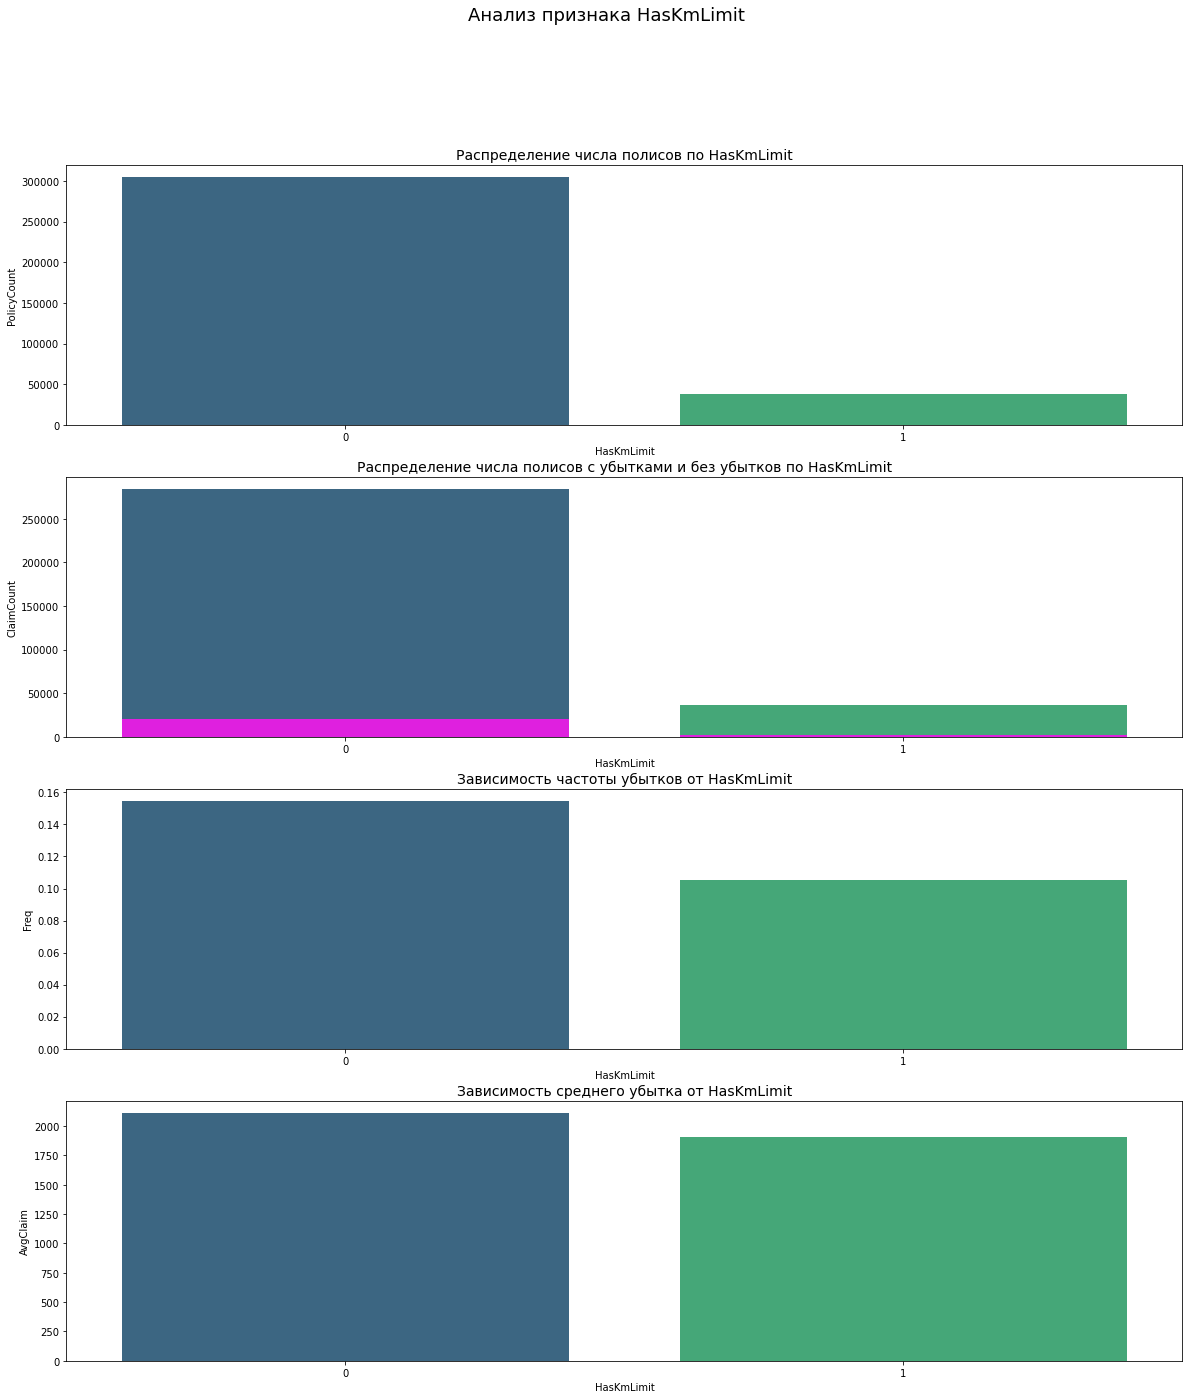

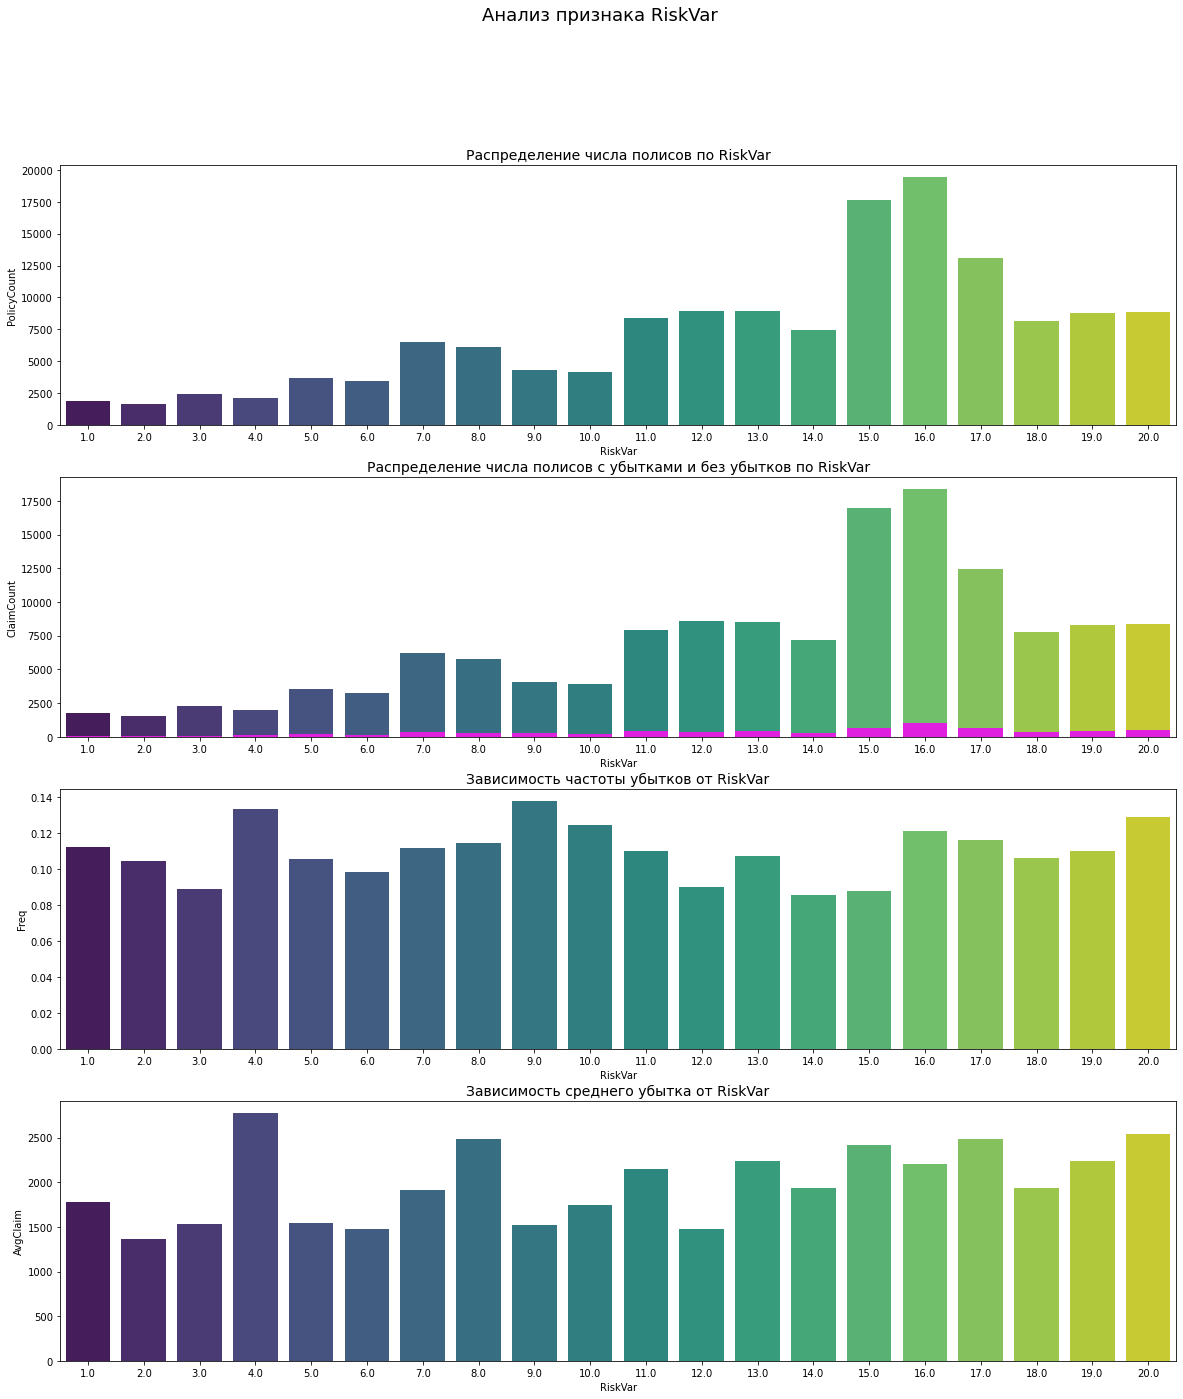

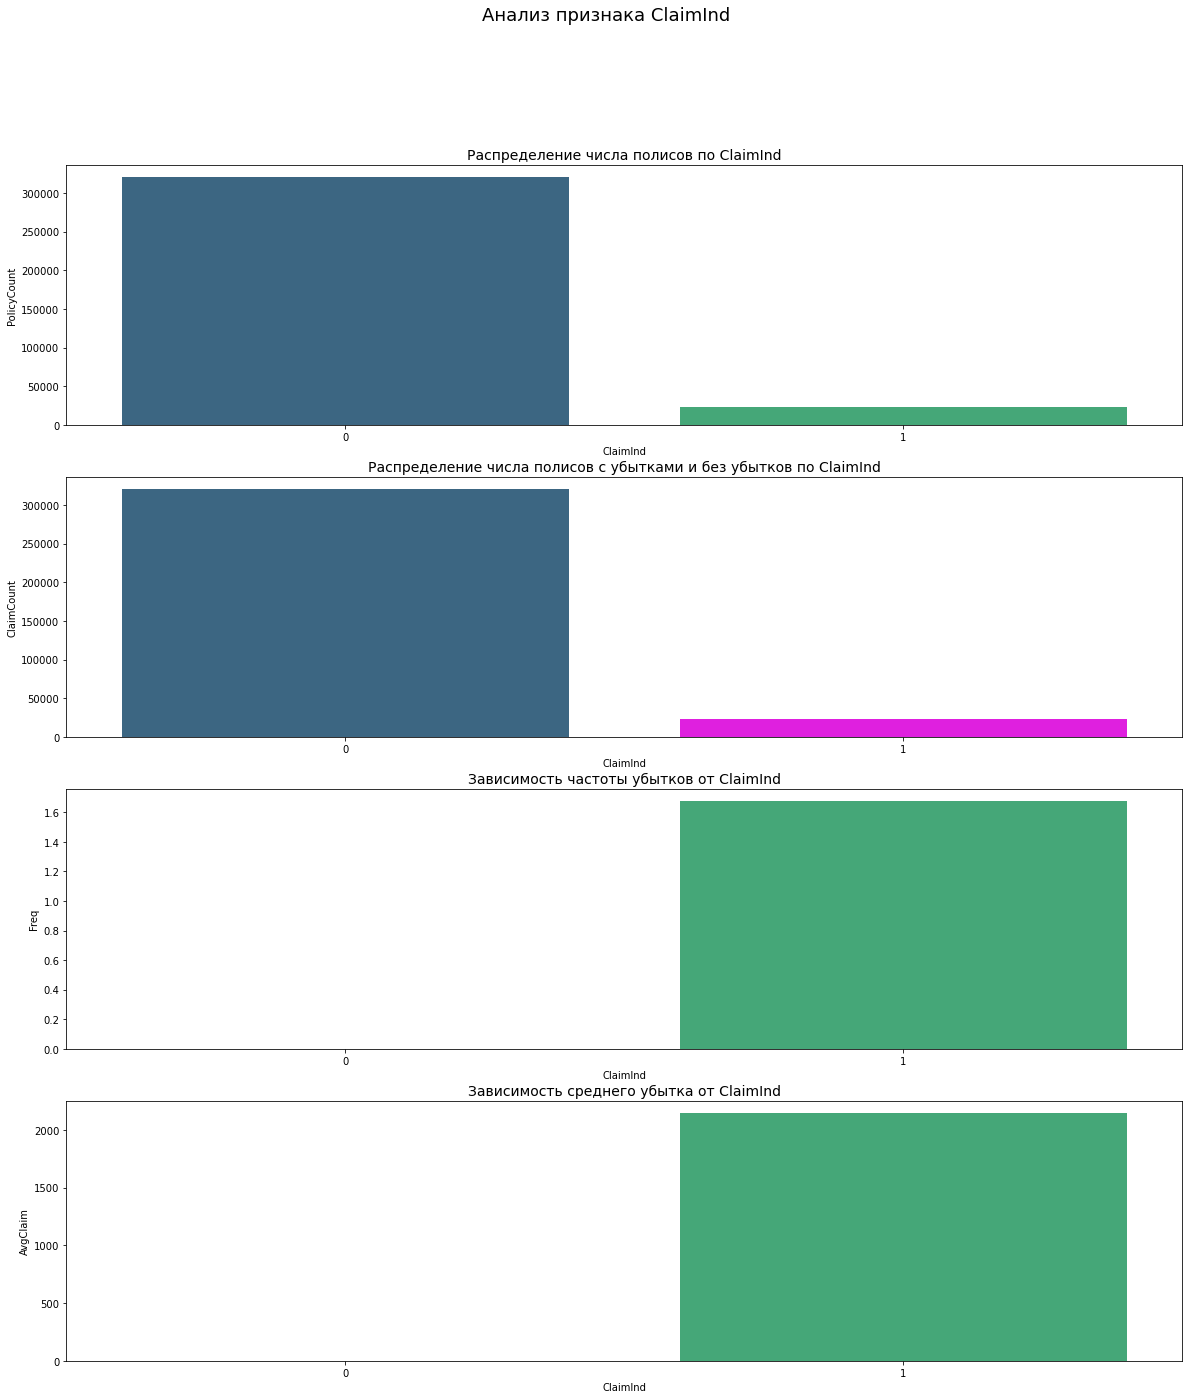

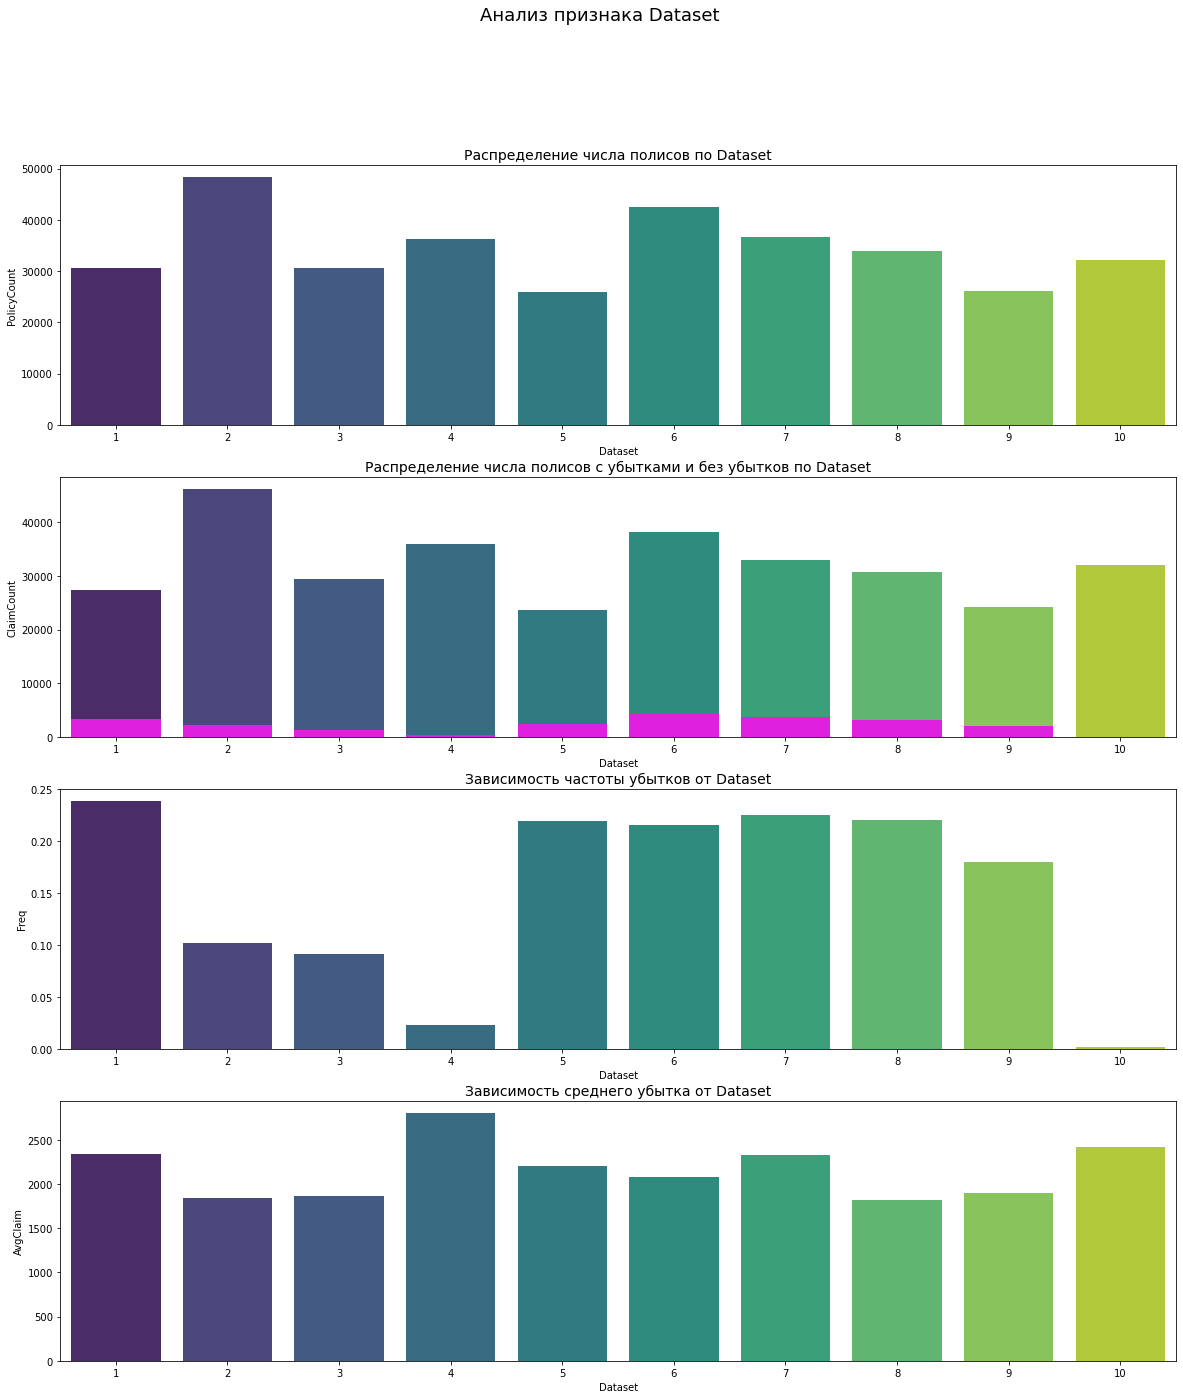

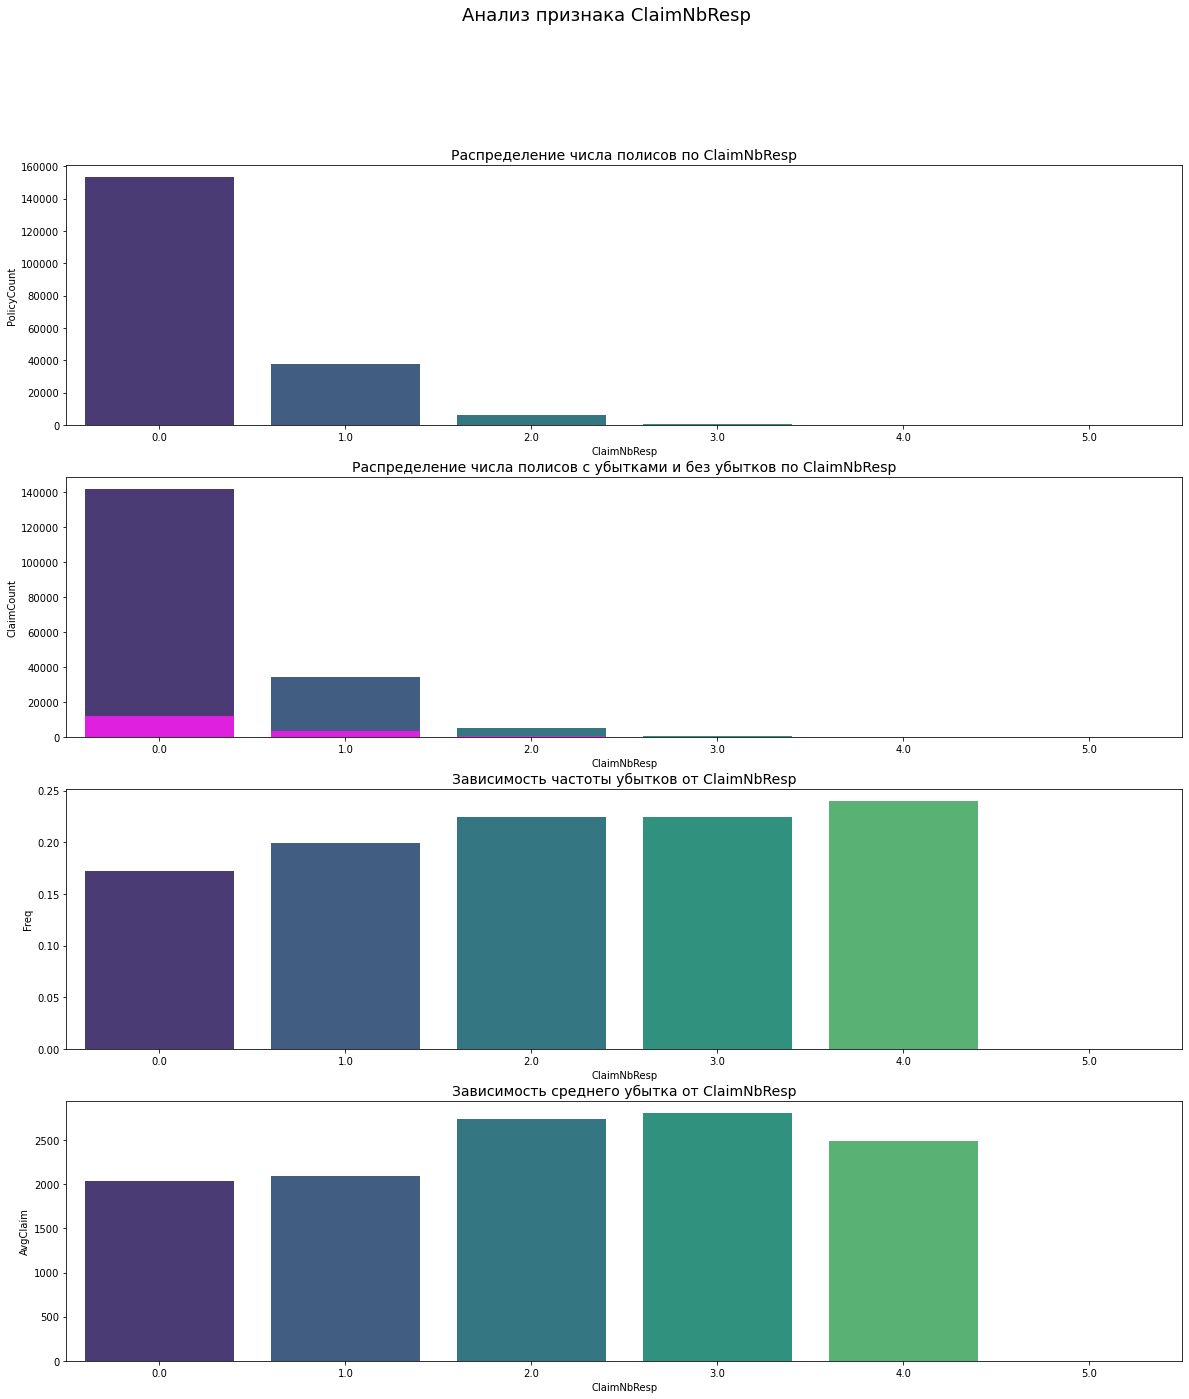

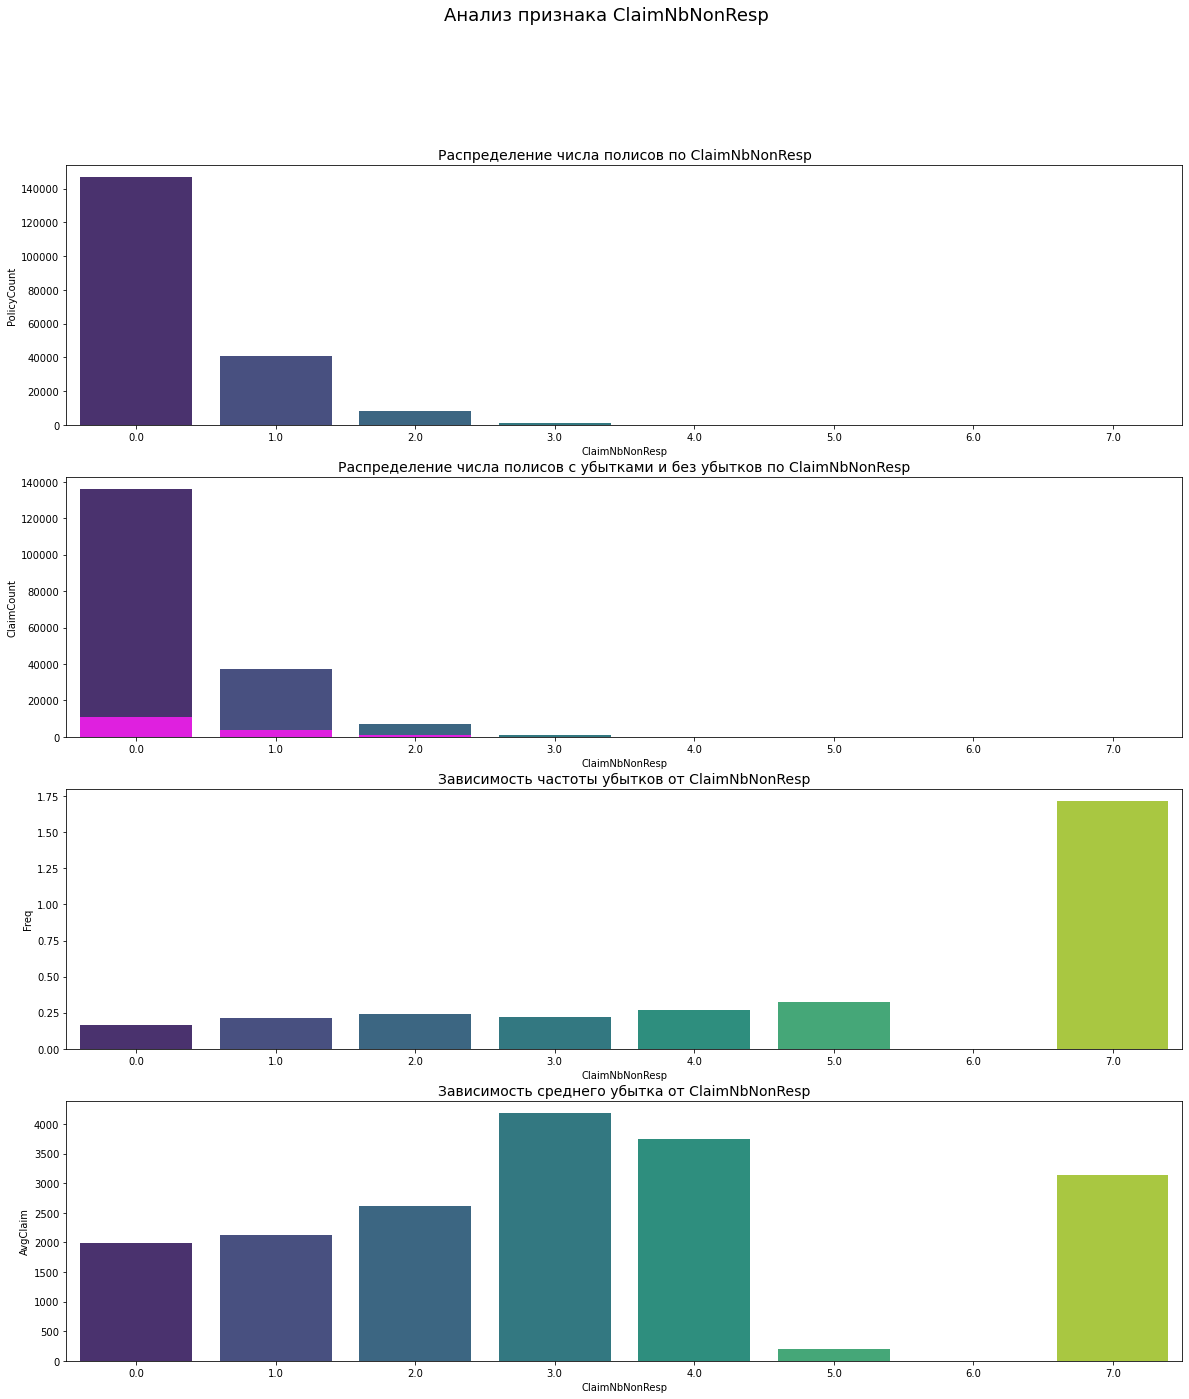

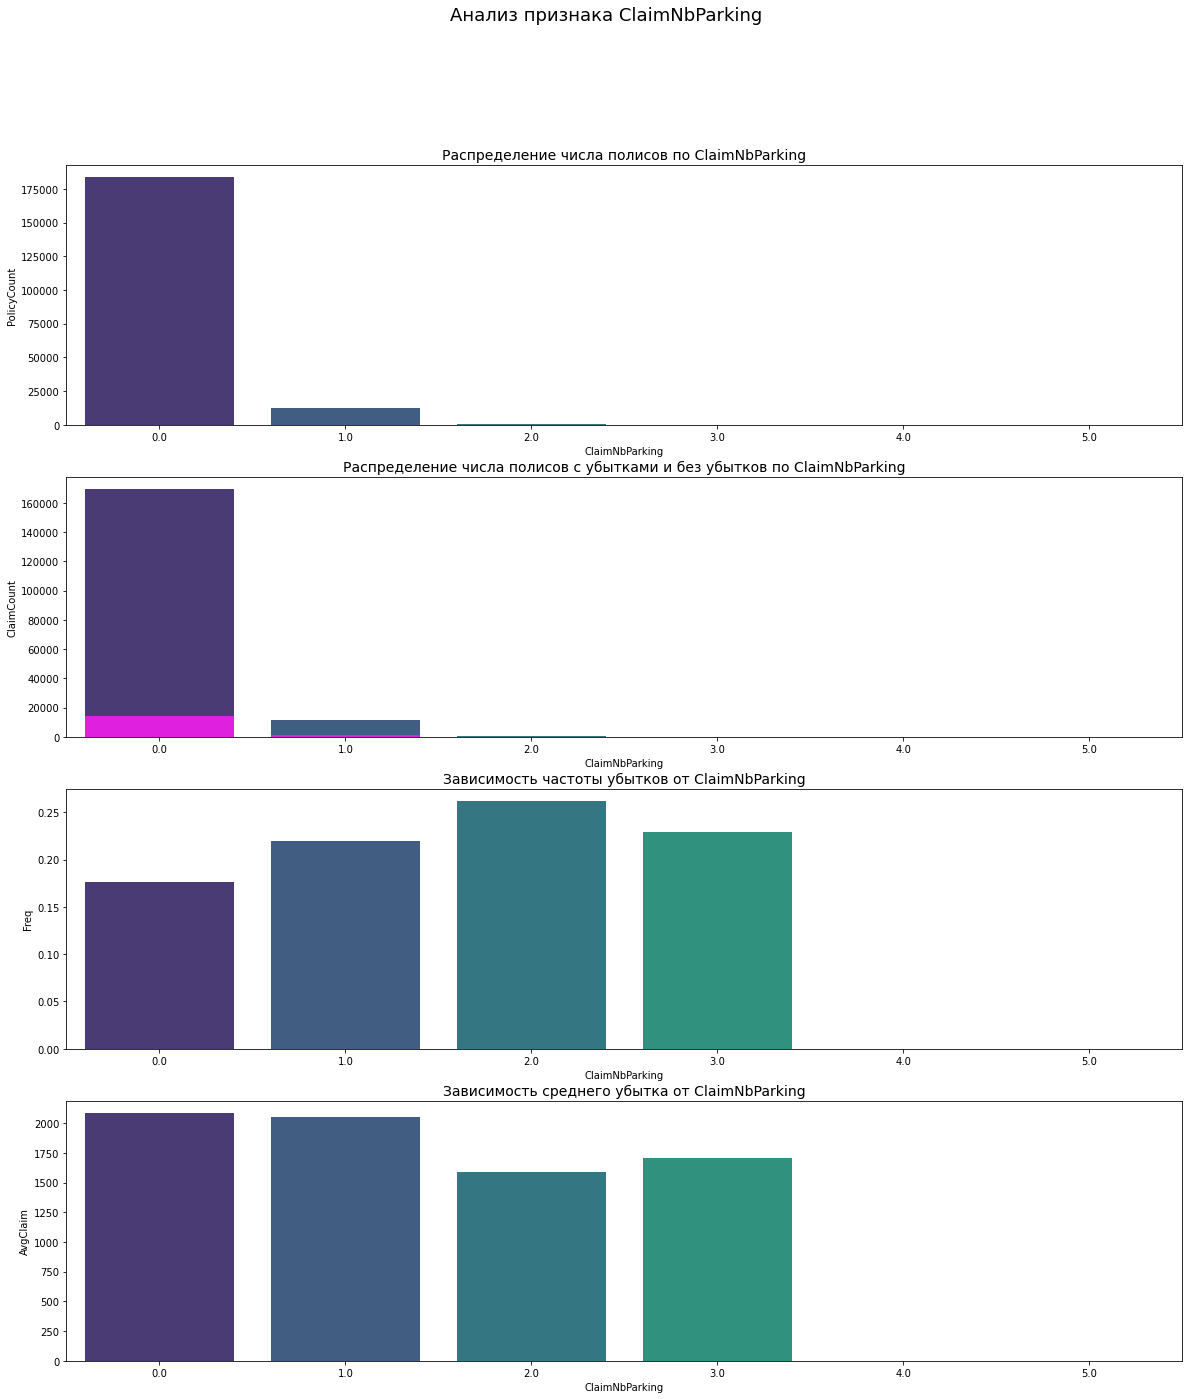

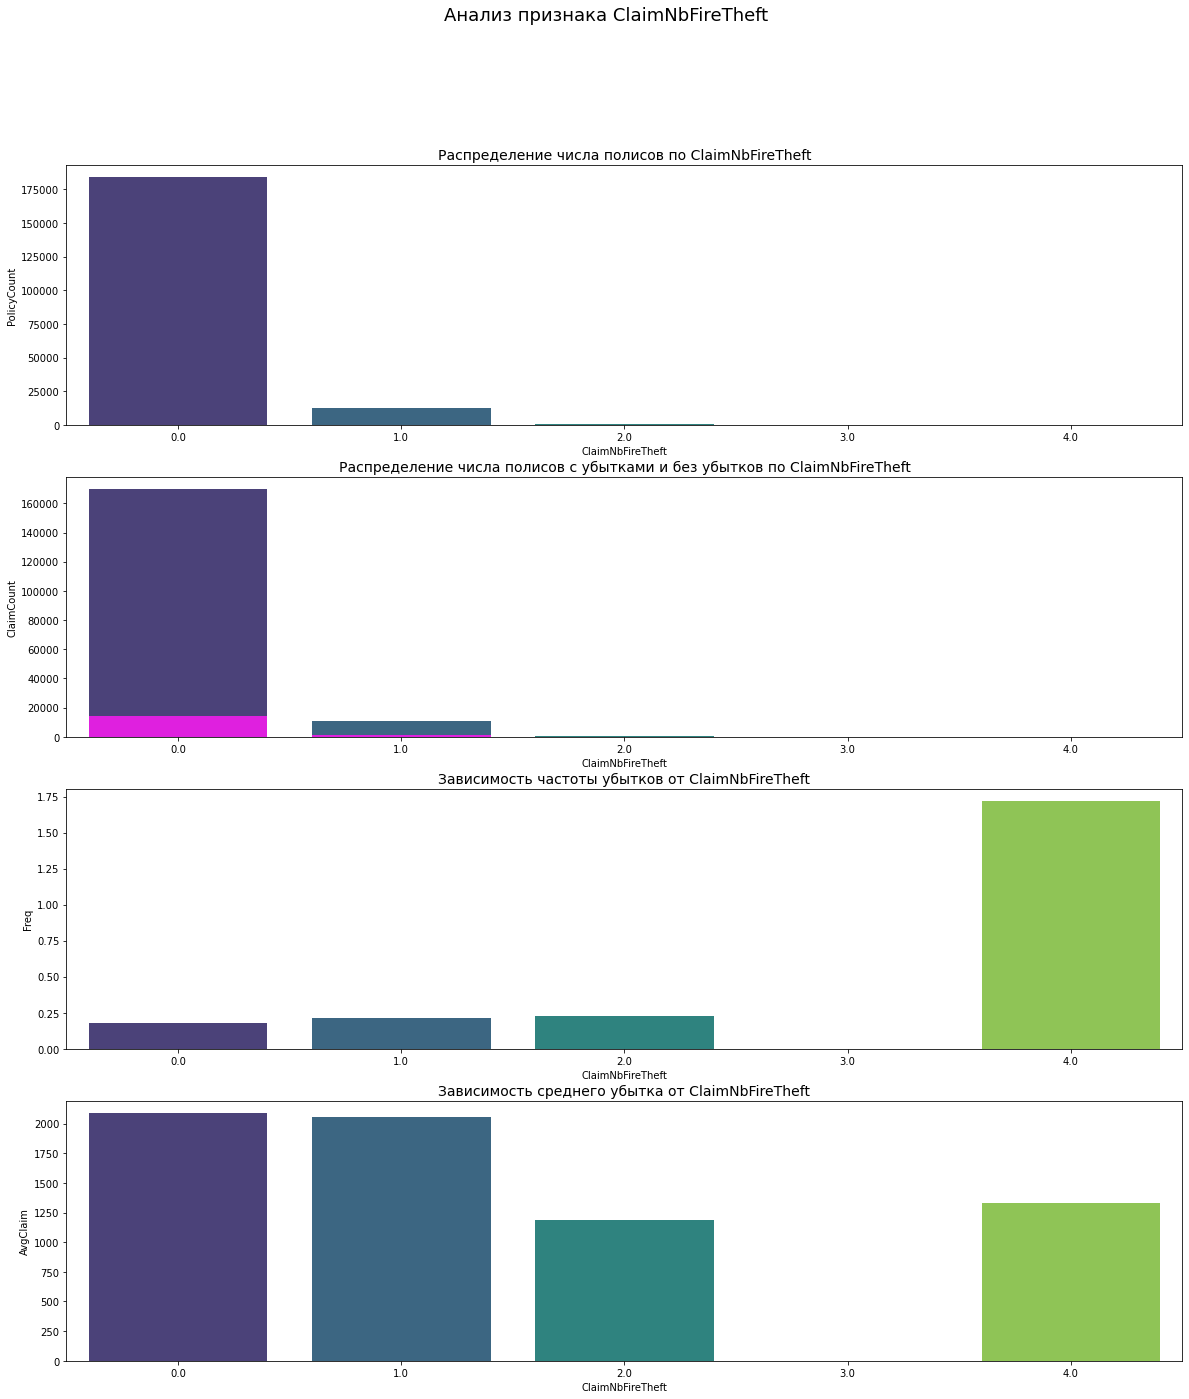

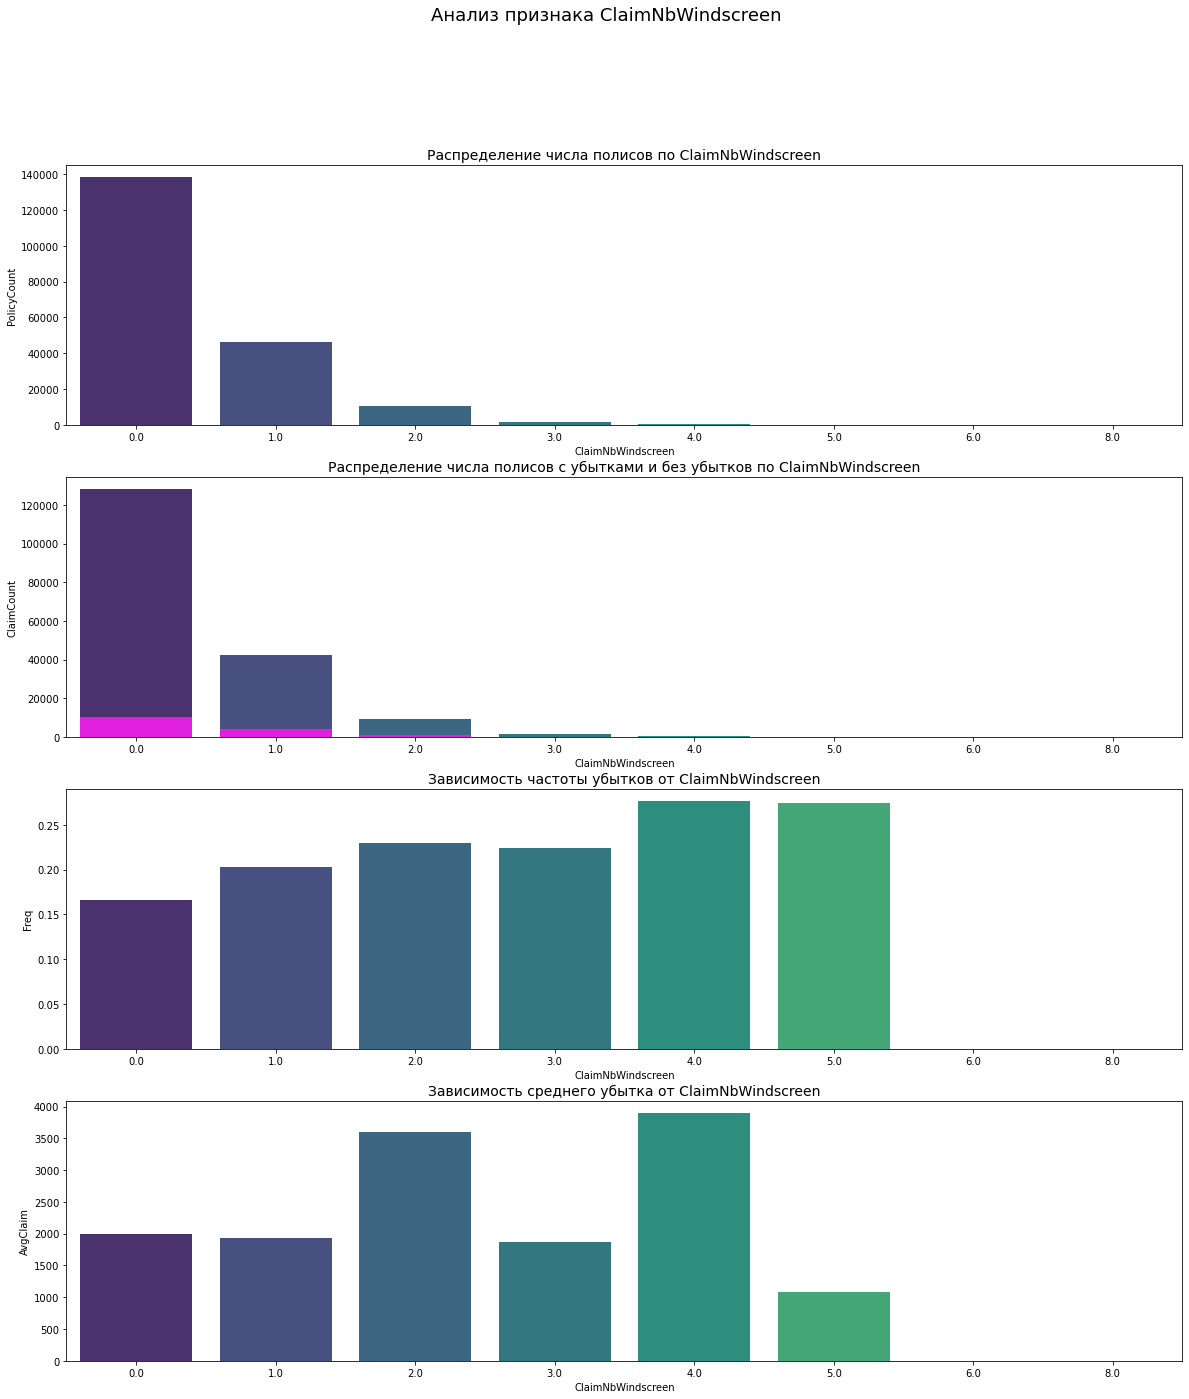

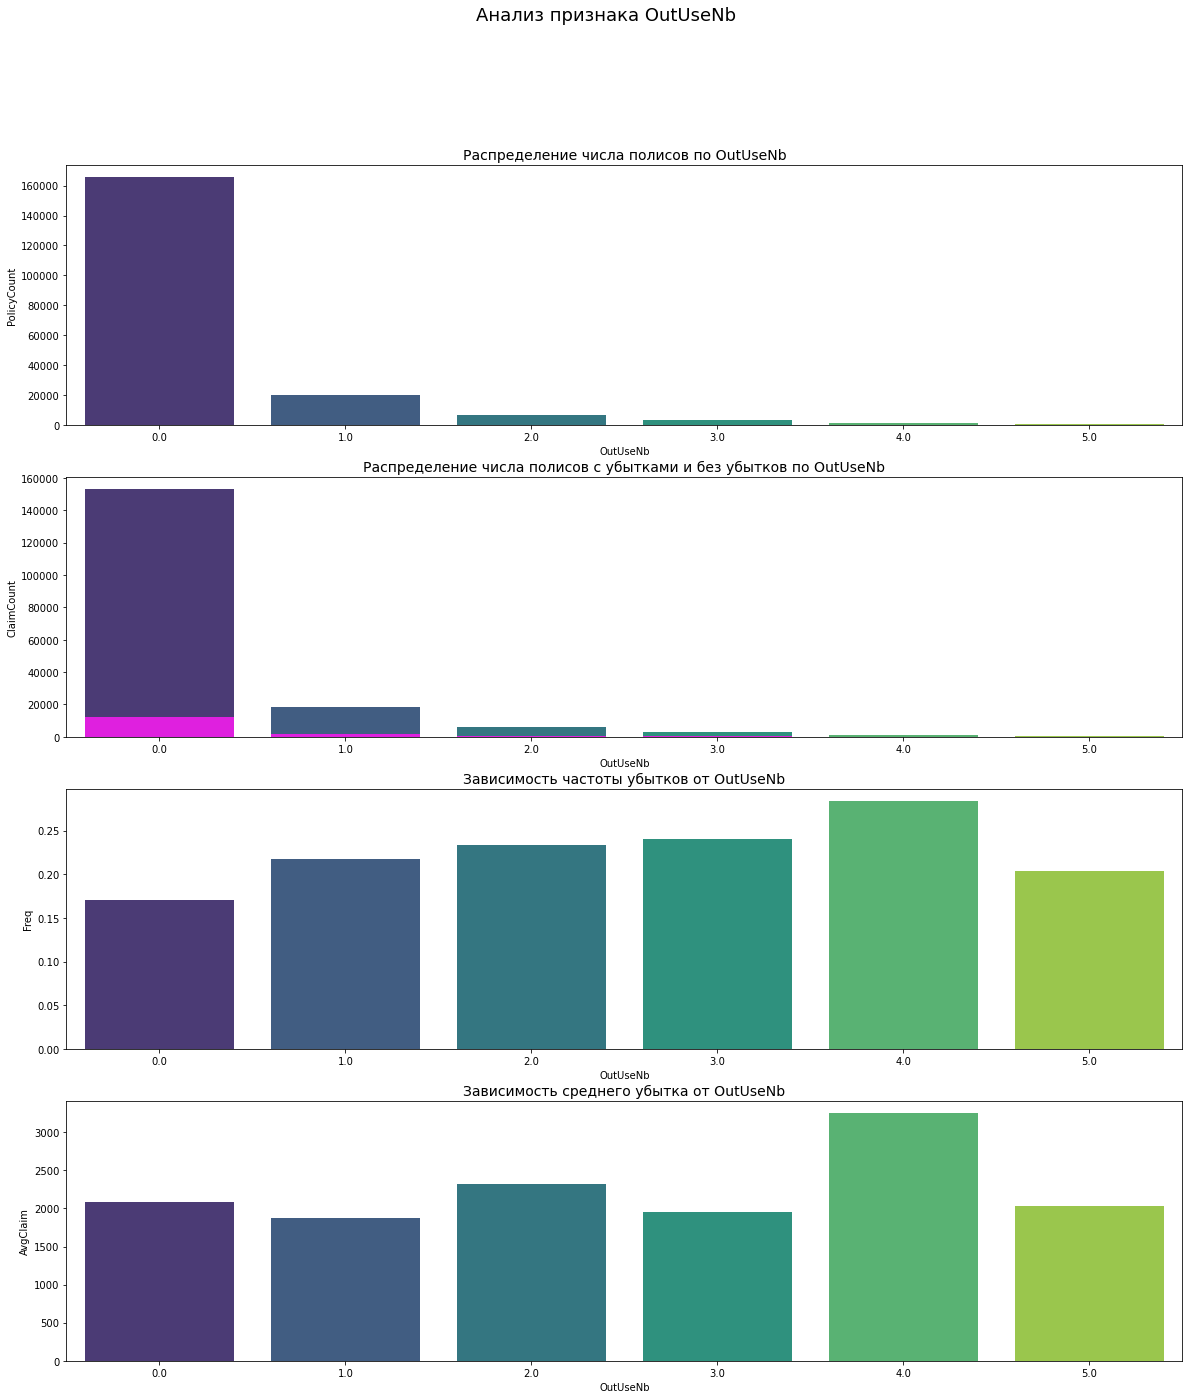

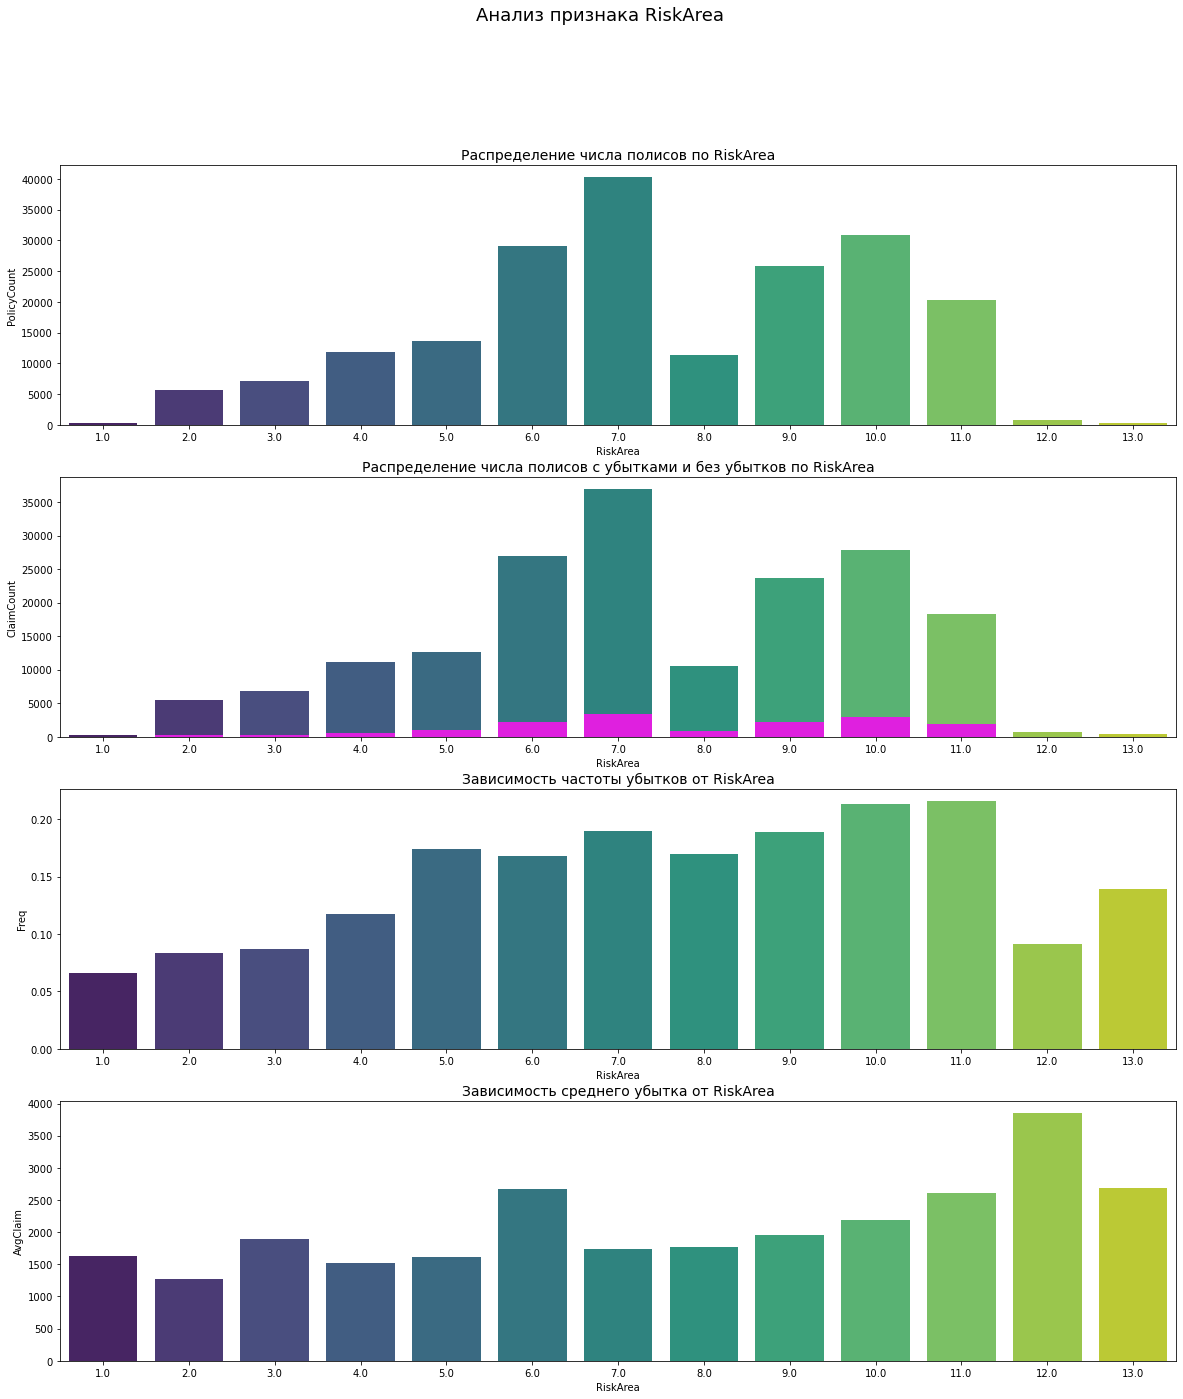

In [13]:
for var_name in DISCRETE_FEATURE_NAMES:    
    plot_dependencies(df, var_name)

#### Выводы:
* __HasKmLimit__ Только небольшая часть полисов имеет признак HasKmLimit. Признак соответствует как меньшей частоте убытков, так и меньшему среднему убытку.
* __RiskVar__ Наибольшее количество полисов имеет признак RiskVar=15-17. Наблюдается слабая зависимость среднего убытока от RiskVar.
* __ClaimInd__ ClaimInd=1 означает наличие убытка, ClaimInd=0 - отсутствие убытка. Удельный вес полисов с ClaimInd=1 сравнительно небольшой.
* __Dataset__ Данные датасетах имеют разное распределение. В части частоты убытков, распределение данных в датасетах 2, 3, 4, 9 и 10 существенно отличается от распределения данных в датасетах 1, 5, 6, 7, 8. Средний убыток в датасетах также существенно отличается. В датасетах 4 и 10 число полисов с убытками минимально, как и частота убытков.
* __ClaimNbResp__ Основное число полисов находится в ClaimNbResp=0 и 1, в них сосредоточены и основные убытки. С увеличением значения признака ClaimNbResp увеличивается частота убытков, но это может быть связано с недостаточным числом наблюдений. ClaimNbResp=5 практически не вствречается. Самый высокий средний убыток наблюдается при ClaimNbResp=3.
* __ClaimNbNonResp__ Основное число полисов находится в ClaimNbNonResp=0 и 1,  в них сосредоточены и основные убытки. Самая высокая частота убытков встречается при ClaimNbNonResp=7, но это может быть связано с недостаточным числом наблюдений. Самый высокий средний убыток - при ClaimNbNonResp=3.
* __ClaimNbParking__ Основное число полисов сосредоточено в ClaimNbParking=0 и 1, основные убытки - в ClaimNbParking=0, остальные данные нематериальны. Самая высокая частота убытков встречается при ClaimNbParking=2, Самый высокий средний убыток - при ClaimNbParking=0.
* __ClaimNbFireTheft__ Основное число полисов сосредоточено в ClaimNbFireTheft=0 и 1, основные убытки - в ClaimNbFireTheft=0, остальные данные нематериальны. Самая высокая частота убытков встречается при ClaimNbFireTheft=4, но это может быть связано с недостаточным количеством данных.
* __ClaimNbWindscreen__ Основное число полисов находится в ClaimNbWindscreen=0 и 1, в них сосредоточены основные убытки, остальные данные нематериальны. Частота убытков растет  с ClaimNbWindscreen=1 до ClaimNbWindscreen=4 и 5, самый высокий средний убыток - при ClaimNbWindscreen=4.
* __OutUseNb__ Основное число полисов находится в OutUseNb=0 и 1, в них сосредоточены основные убытки, остальные данные нематериальны. Частота убытков растет  с OutUseNb=1 до OutUseNb=4, при OutUseNb=5 - снижается. Самый высокий средний убыток - при OutUseNb=4.
* __RiskArea__ Самое большое число полисов, как и самое большое число полисов с убытками, находистя в RiskArea=7. Частота убытков растет  с RiskArea=1 до RiskArea=11, затем снижается, точнее, ведет себя нестабильно. Средний убыток растет до RiskArea=12, потом снижается при RiskArea=13.

#### 2. Непрерывные признаки

In [14]:
def plot_distribution(df, var_name):
    plt.figure(figsize=(8, 3.5))
    sns.distplot(df[var_name], color='indigo')
    plt.title(f'Распределение признака {var_name}', size=14)    
    plt.show()

In [15]:
CONTINUOUS_FEATURE_NAMES = []
for name in NUMERICAL_FEATURE_NAMES:
    if not name in DISCRETE_FEATURE_NAMES:
        CONTINUOUS_FEATURE_NAMES.append(name)
        
data[CONTINUOUS_FEATURE_NAMES].head()      

,Exposure,BonusMalus,ClaimAmount
0,0.583,72,0.000000
1,0.200,80,0.000000
2,0.083,63,0.000000
3,0.375,63,0.000000
4,0.500,72,1418.610272


In [16]:
data[CONTINUOUS_FEATURE_NAMES].describe()

,Exposure,BonusMalus,ClaimAmount
count,343080.000000,343080.000000,343080.000000
mean,0.441275,62.221590,137.777661
std,0.288110,17.466711,2401.187133
min,0.001000,50.000000,-3407.700000
25%,0.183000,50.000000,0.000000
50%,0.416000,50.000000,0.000000
75%,0.666000,72.000000,0.000000
max,1.000000,272.000000,802620.270997


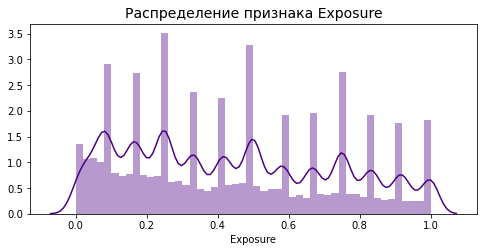

In [17]:
var_name = 'Exposure'
plot_distribution(data, var_name)

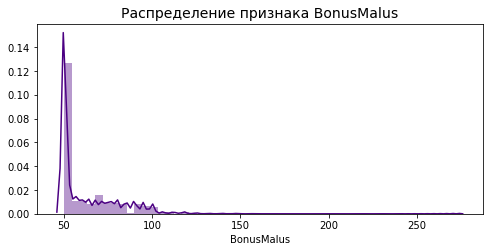

In [18]:
var_name = 'BonusMalus'
plot_distribution(data, var_name)

In [19]:
a = df[var_name].value_counts()
a[a.keys()<=100].sum()/a.sum()

0.9769587268275621

In [20]:
a[50]/a.sum()

0.5074210096770433

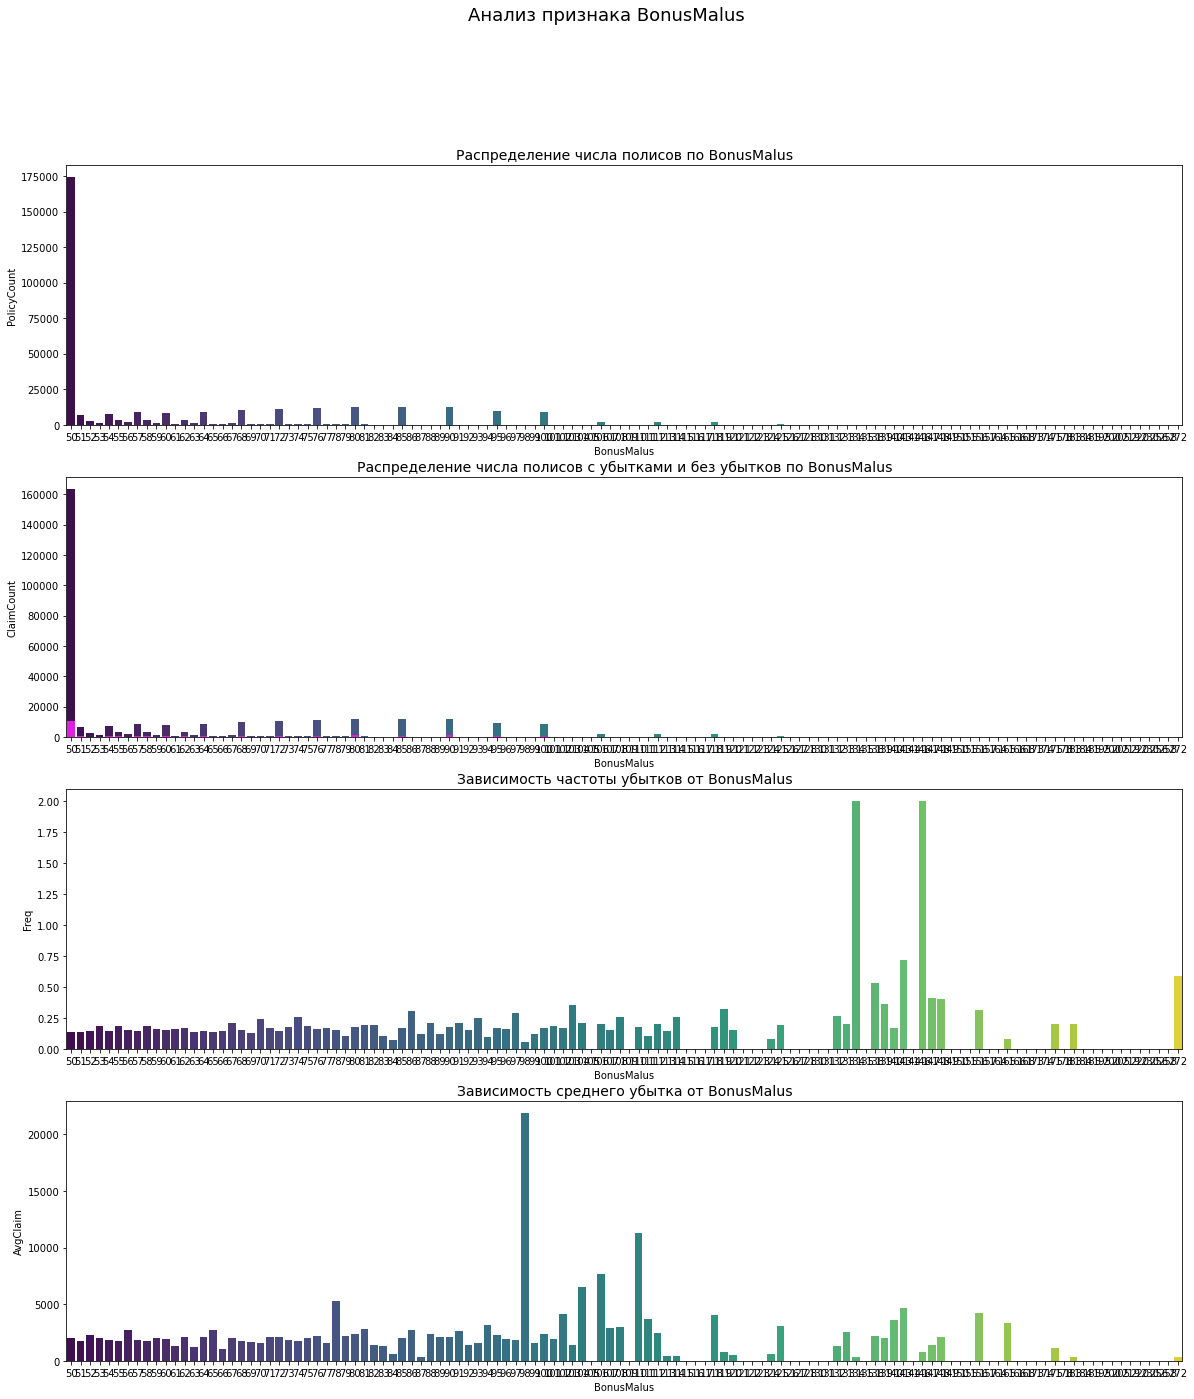

In [21]:
plot_dependencies(df, var_name)

#### Выводы:
* __Exposure__ Значения Exposure более-менее равномерно распределенно на интервале от 0 до 1, с округлениями на начало месяца. Плотность распрпделения снижается от начала года к концу.
* __BonusMalus__ Значения BonusMalus расположены в интервале от 50 до 272. 97.7% значений находится в интервале от 50 до 100, причем больше половины приходится на BonusMalus=50. Каких-то особых зависимостей между BonusMalus и убытком не наблюдается.
* __ClaimAmount__ Максимальное значение ClaimAmount=802620. Минимальное значение - отрицательное, нужна дополнительная информация для обяснения причин такого явления.

### 2.3 Категориальные признаки

In [22]:
CATEGORICAL_FEATURE_NAMES = data[FEATURE_NAMES].select_dtypes(include=[np.object]).columns.to_list()
data[CATEGORICAL_FEATURE_NAMES].head()

,VehAge,VehUsage,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,Garage,DeducType
0,2,Professional,sedan,D,injection,regular,160-170 km/h,B,None,NaN
1,0,Private+trip to office,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,None,NaN
2,1,Professional,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,None,NaN
3,1,Professional,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,Private garage,NaN
4,3,Professional,van,L,direct injection overpowered,diesel,140-150 km/h,0,None,NaN


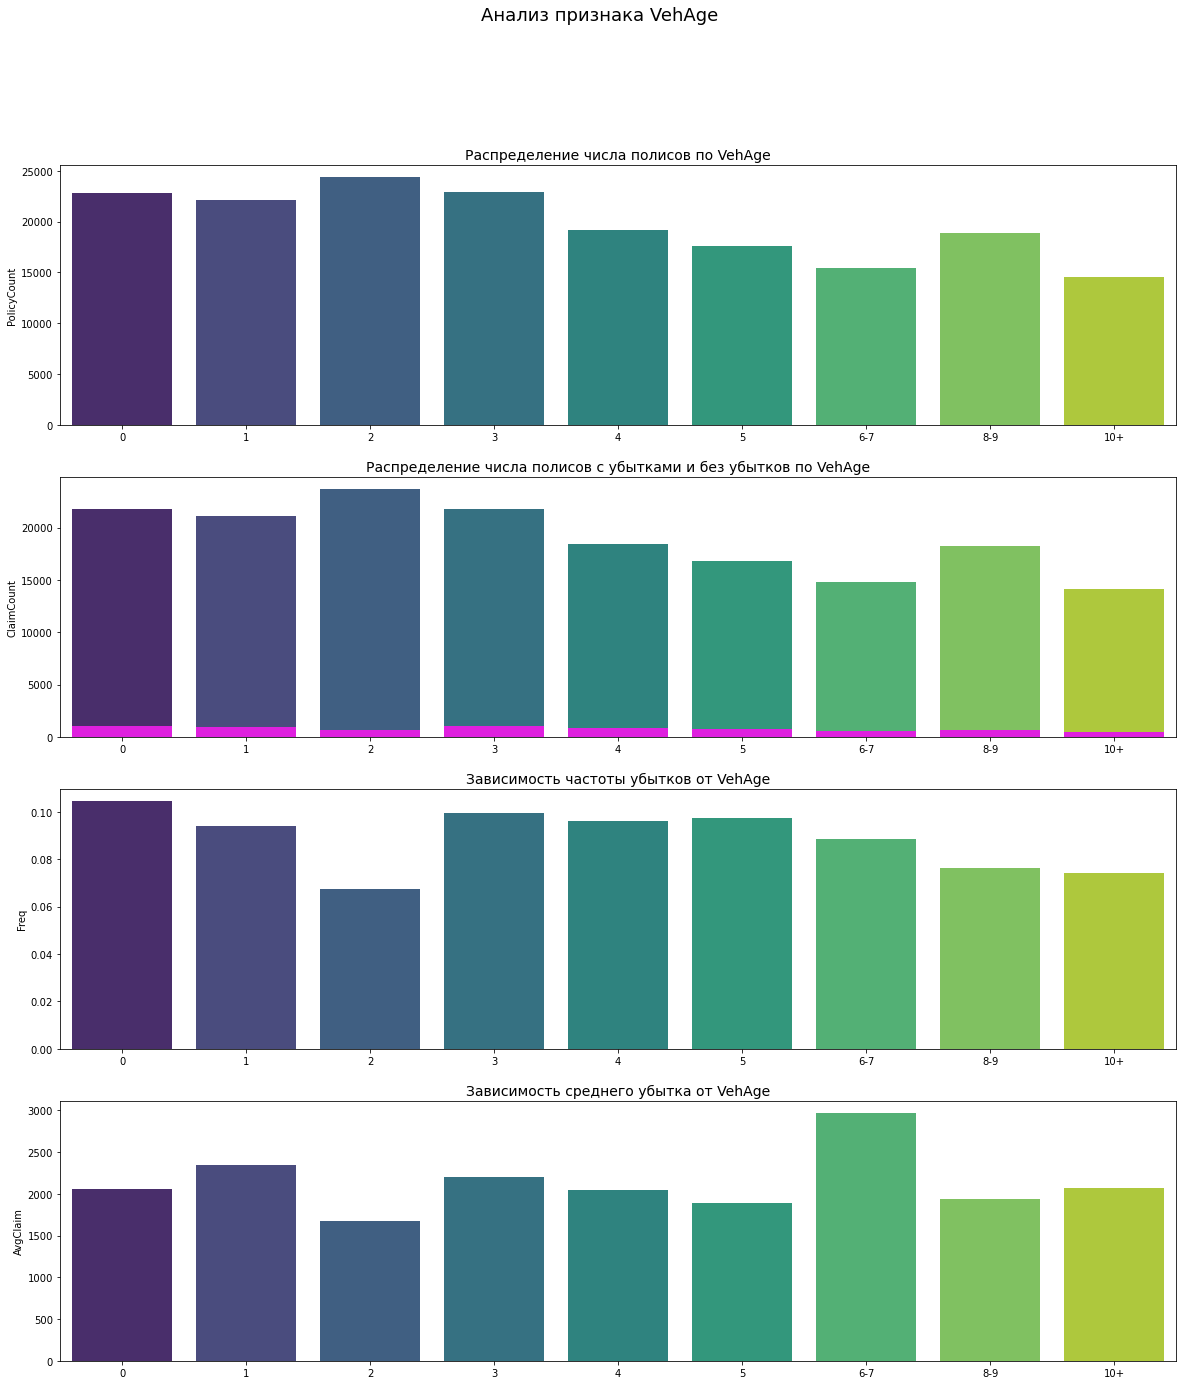

In [23]:
var_name = 'VehAge'
levels = ['0', '1', '2', '3', '4', '5', '6-7', '8-9', '10+']
plot_dependencies(df, var_name, levels=levels)

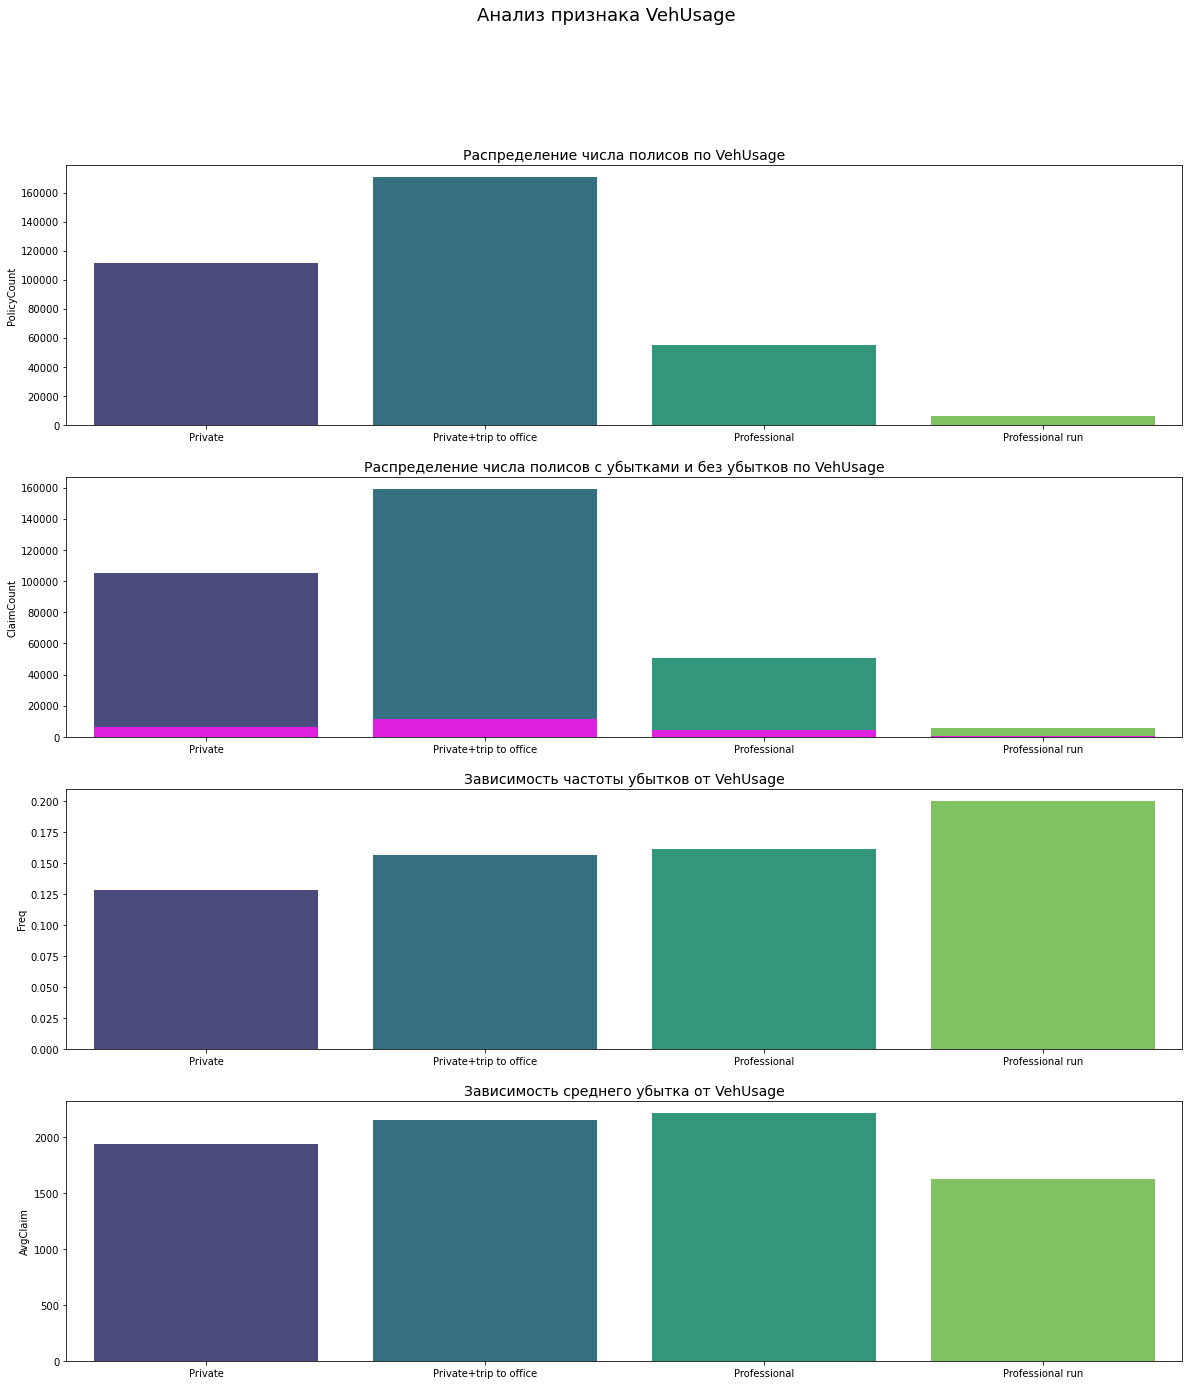

In [24]:
var_name = 'VehUsage'
levels = ['Private', 'Private+trip to office', 'Professional', 'Professional run']
plot_dependencies(df, var_name, levels=levels)

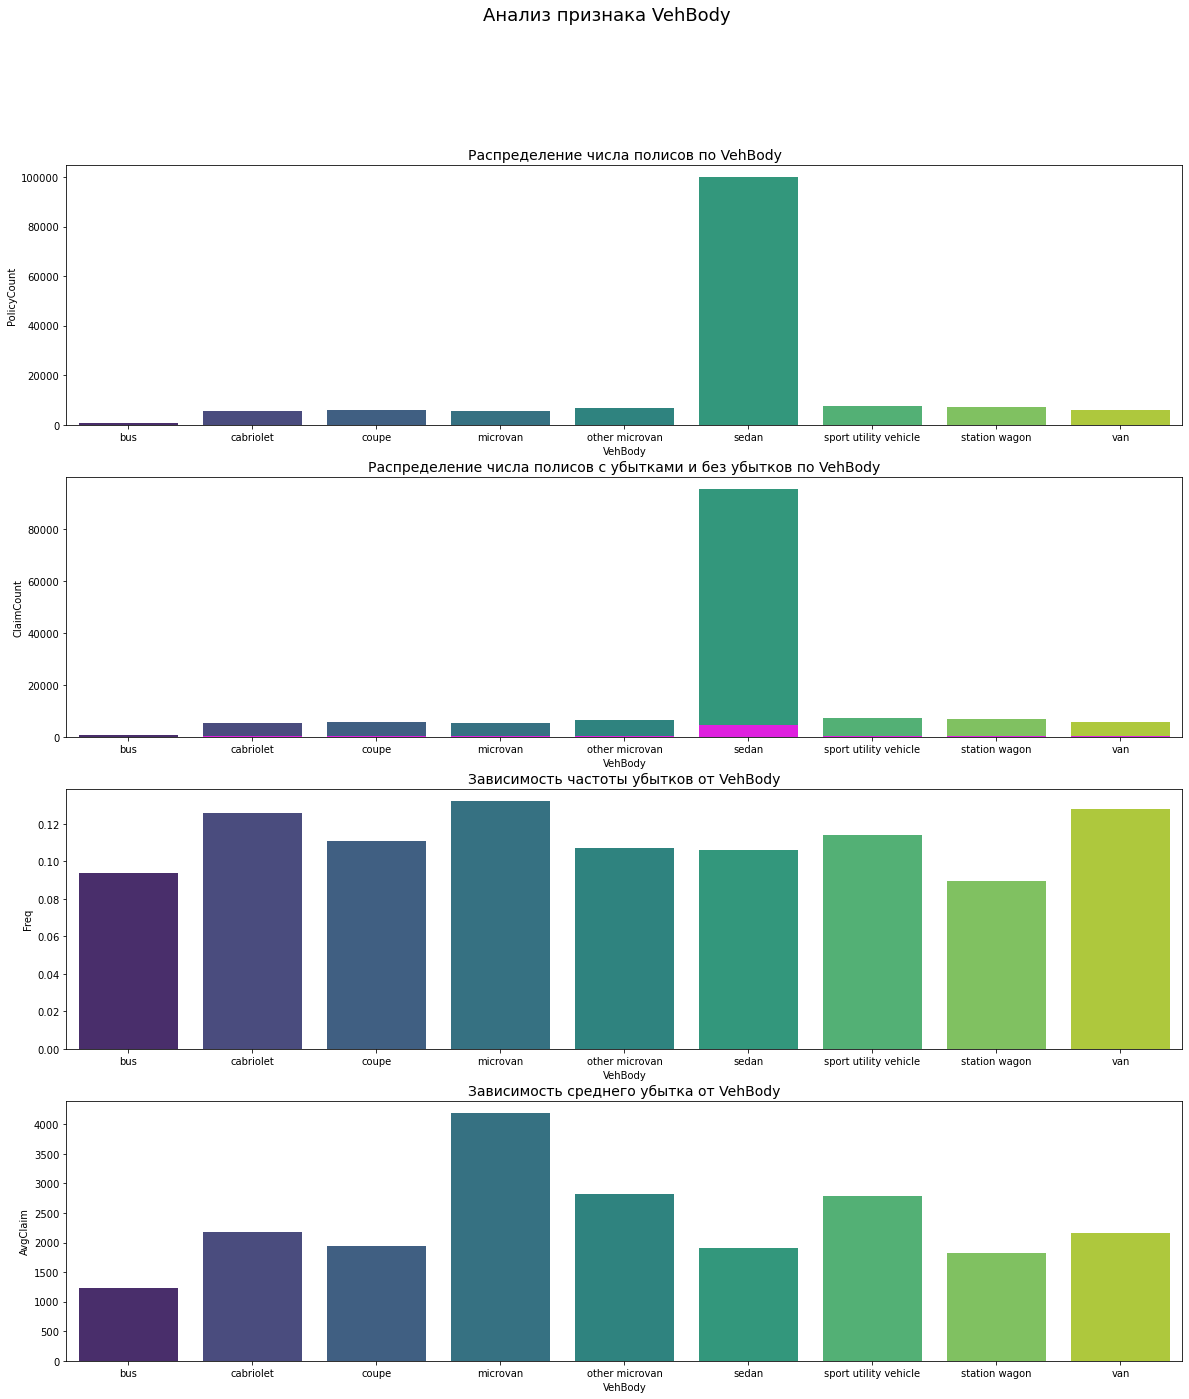

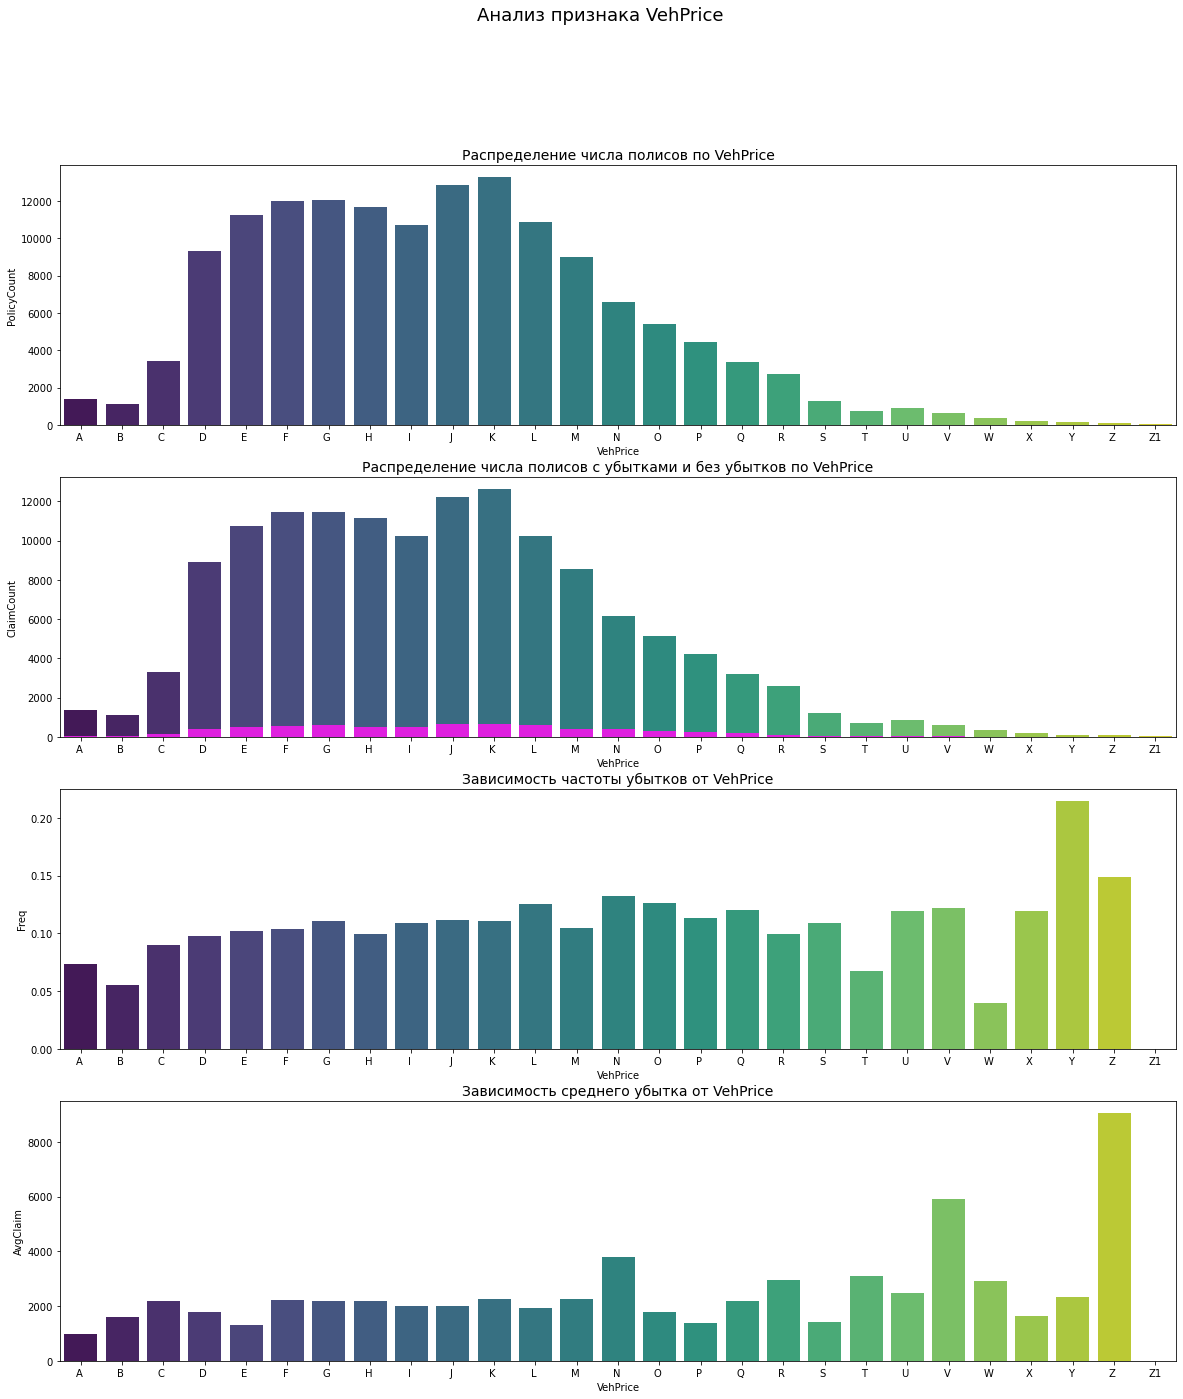

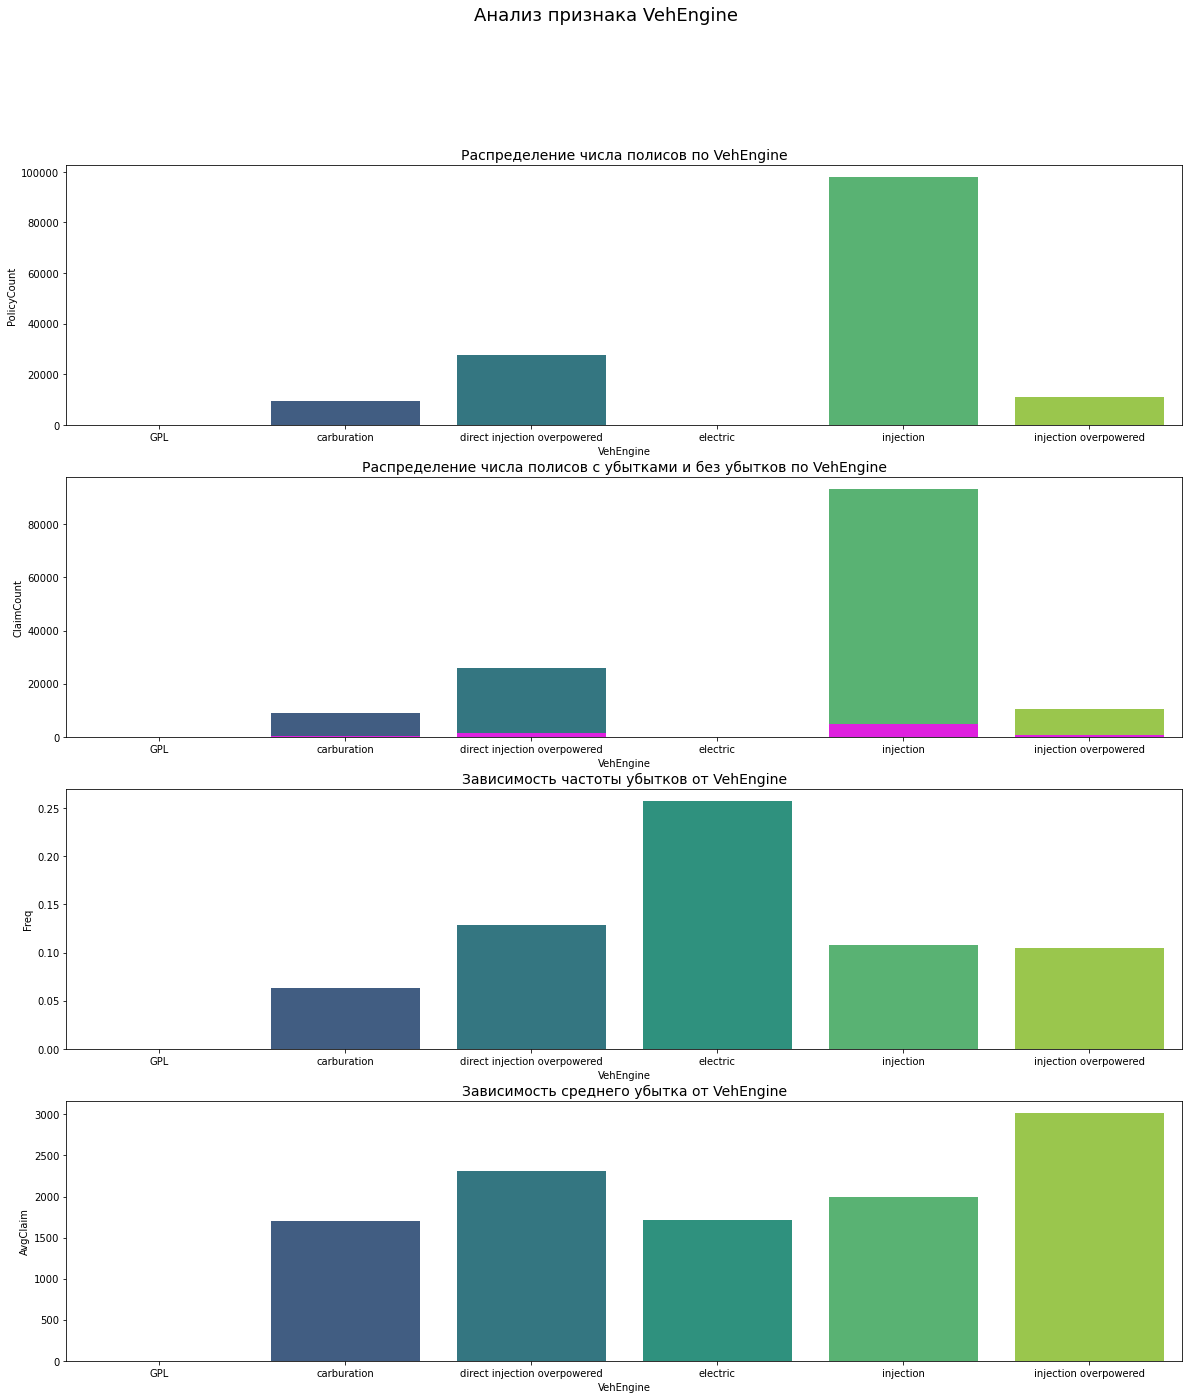

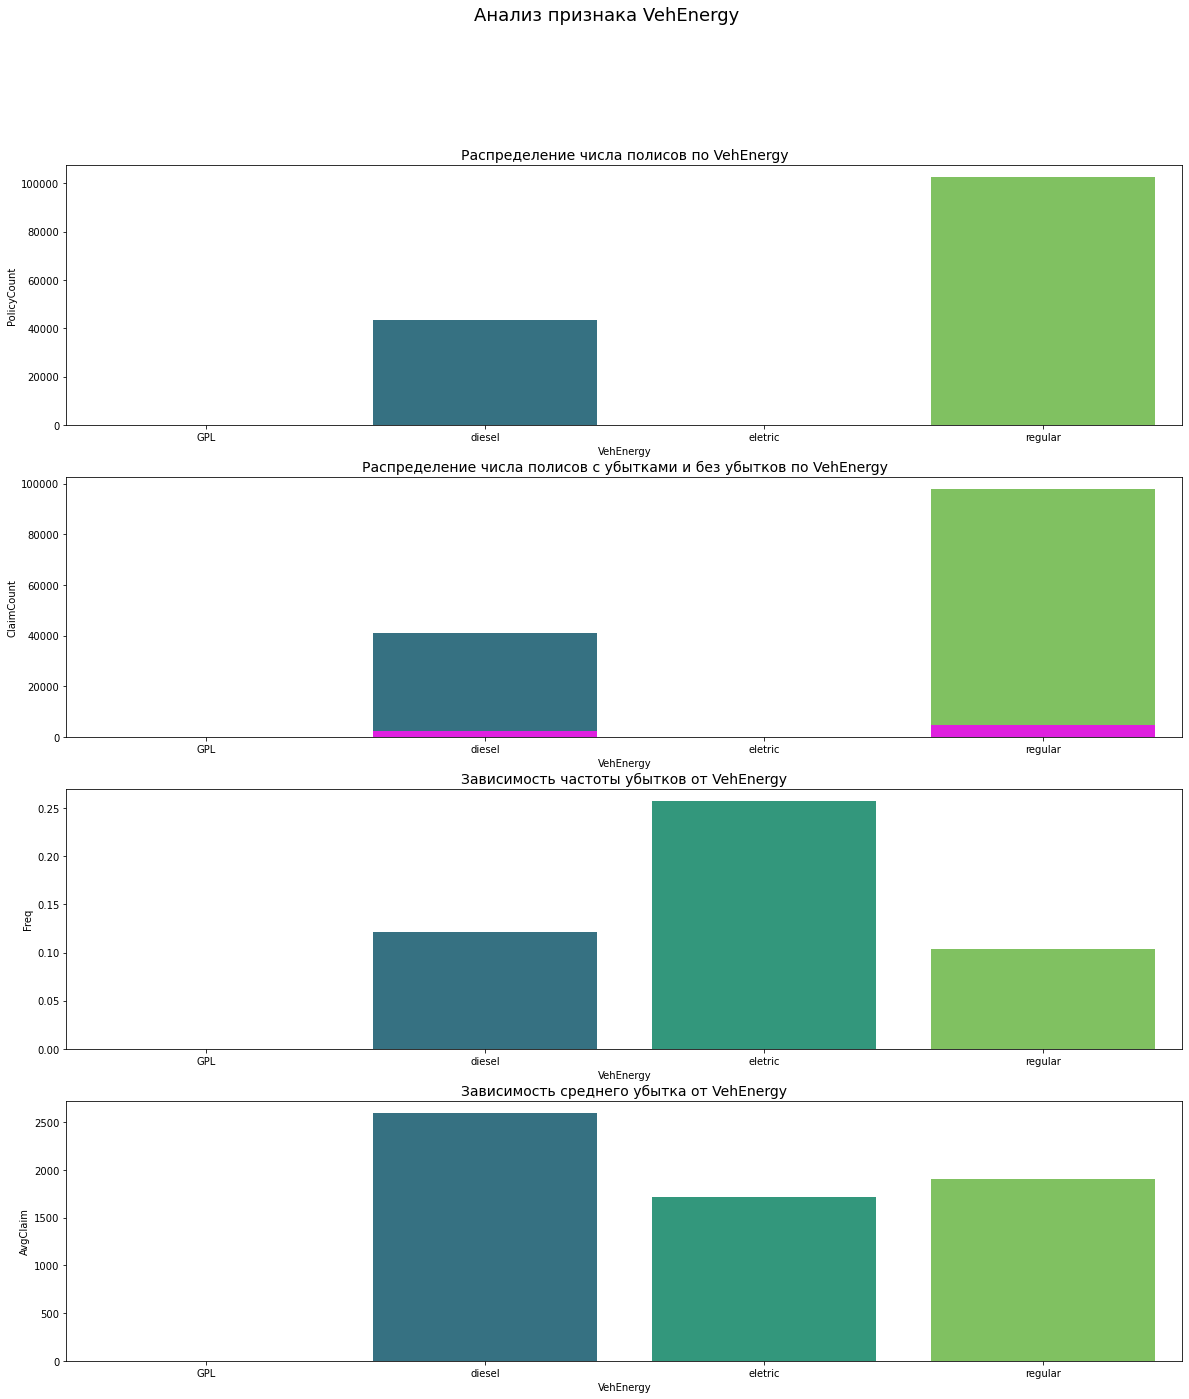

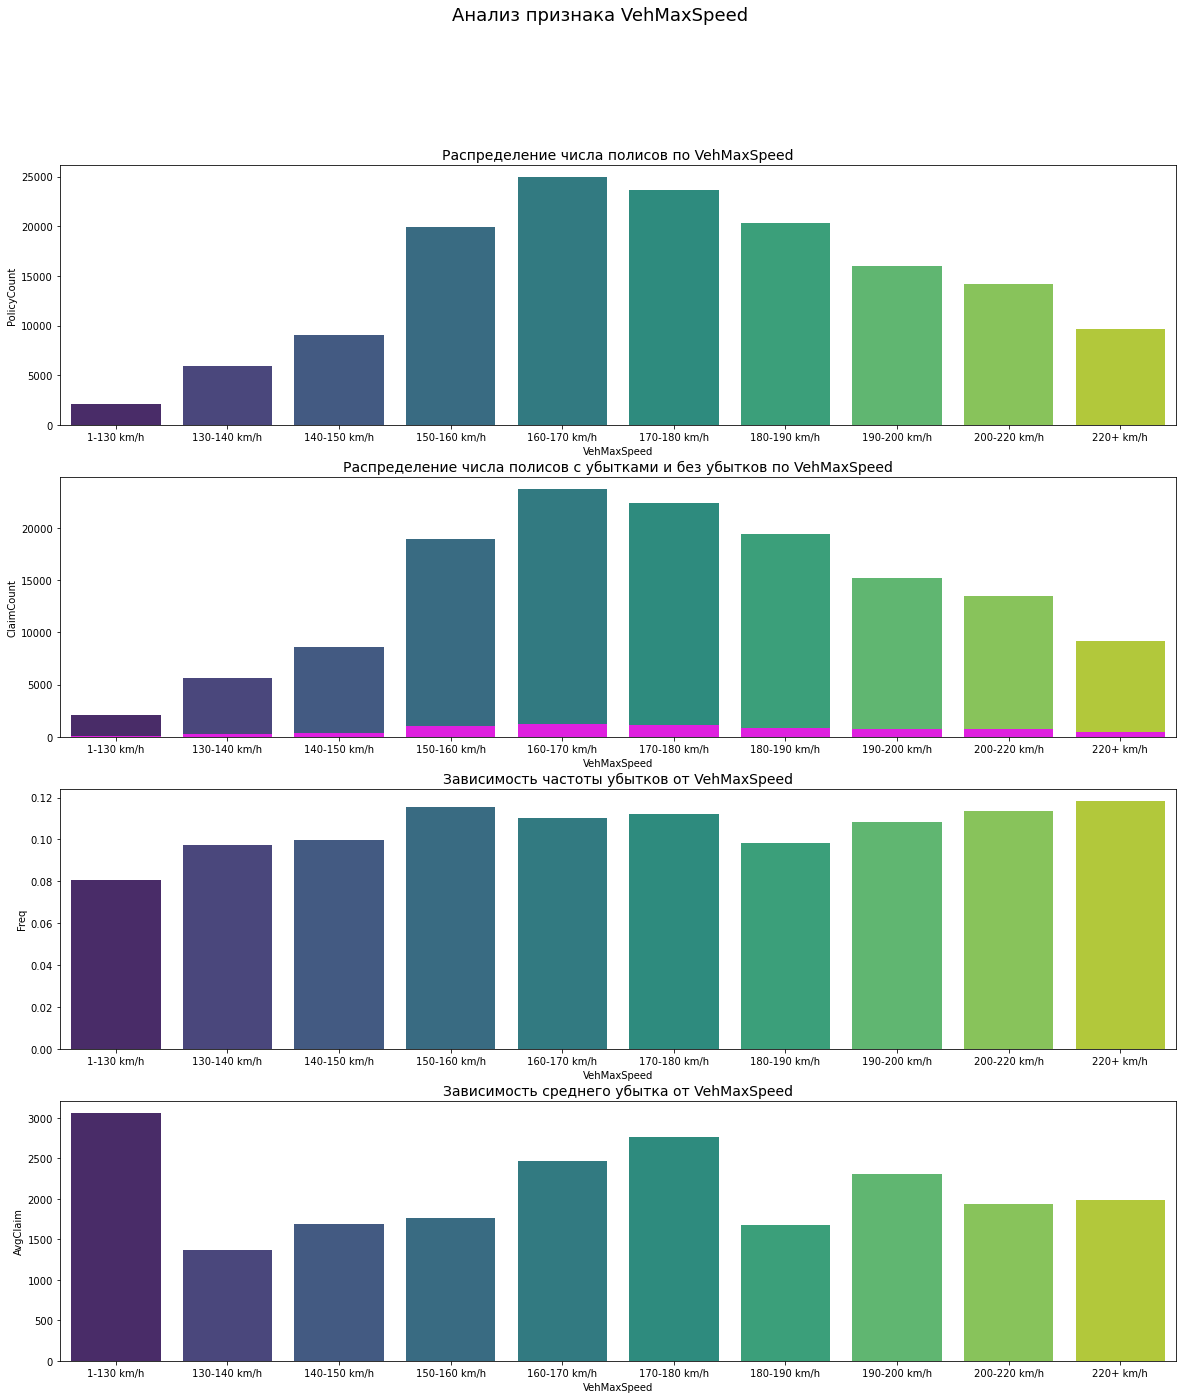

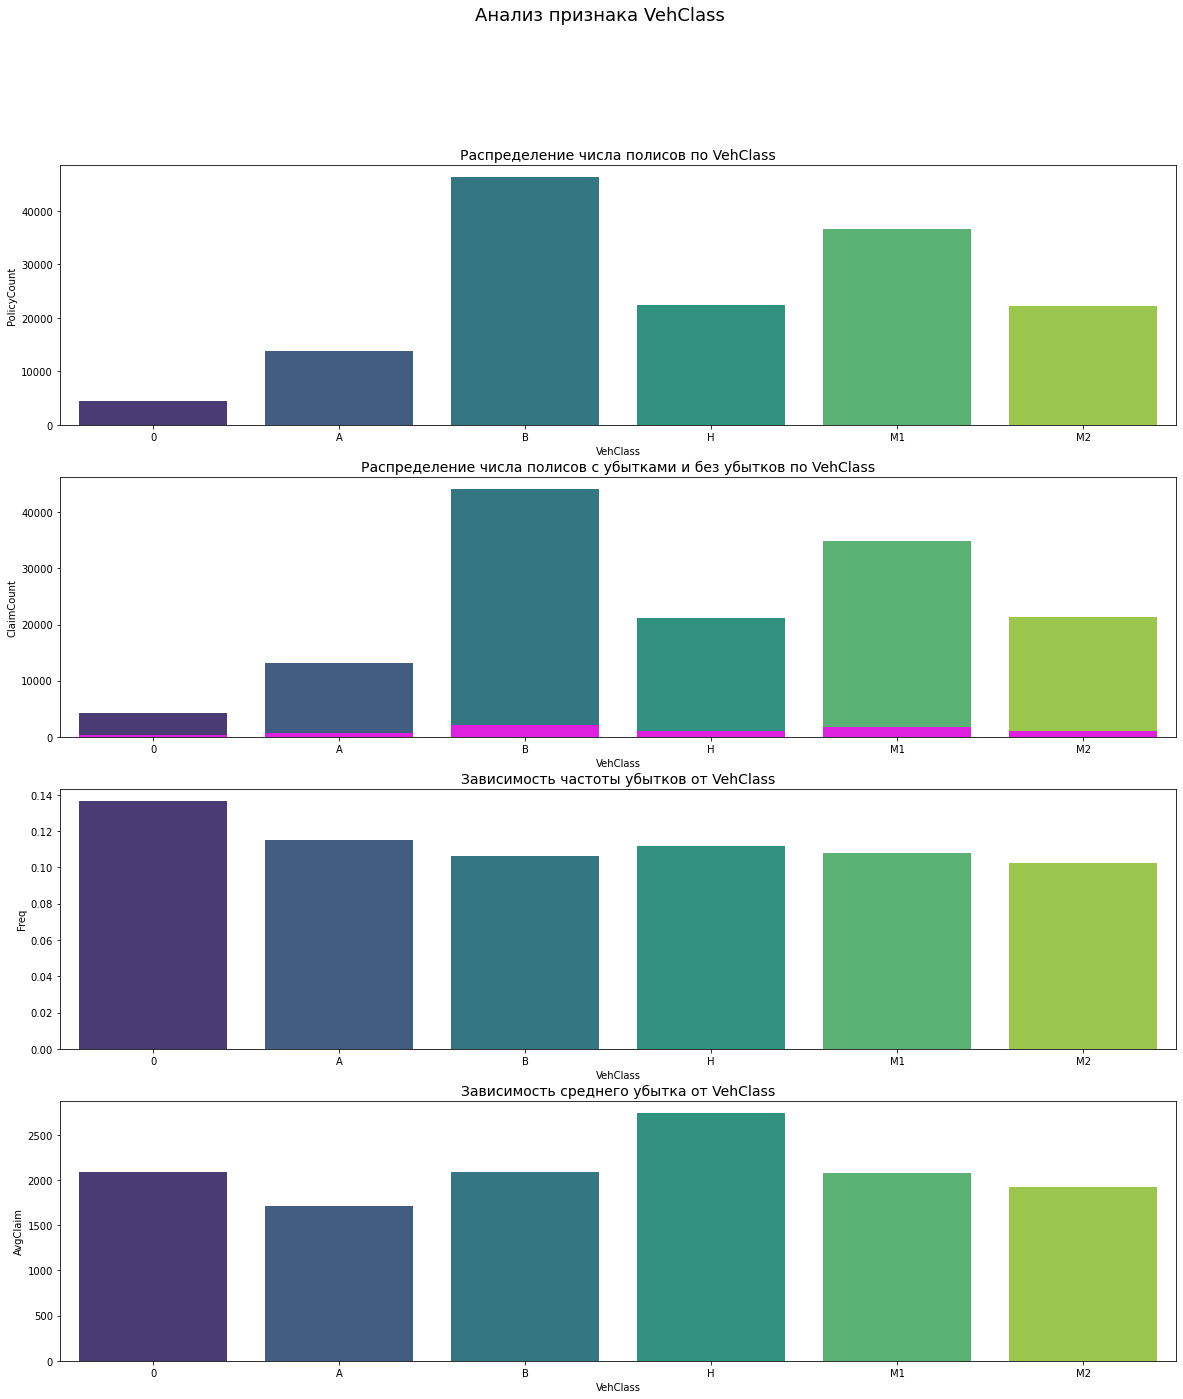

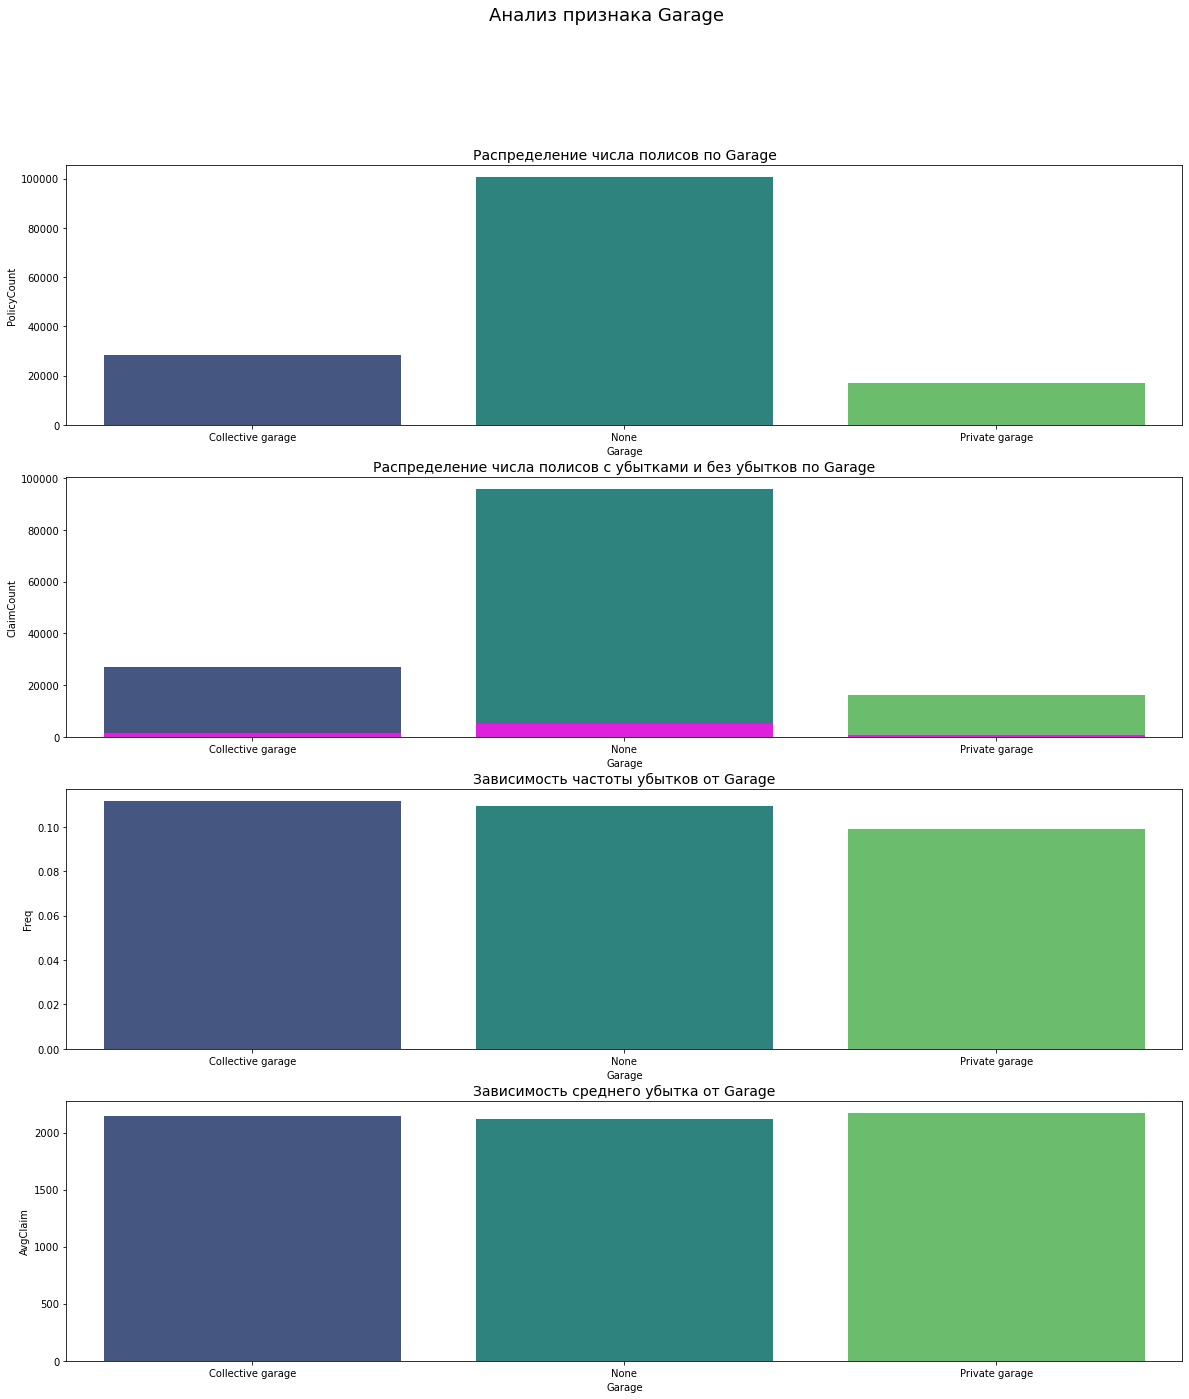

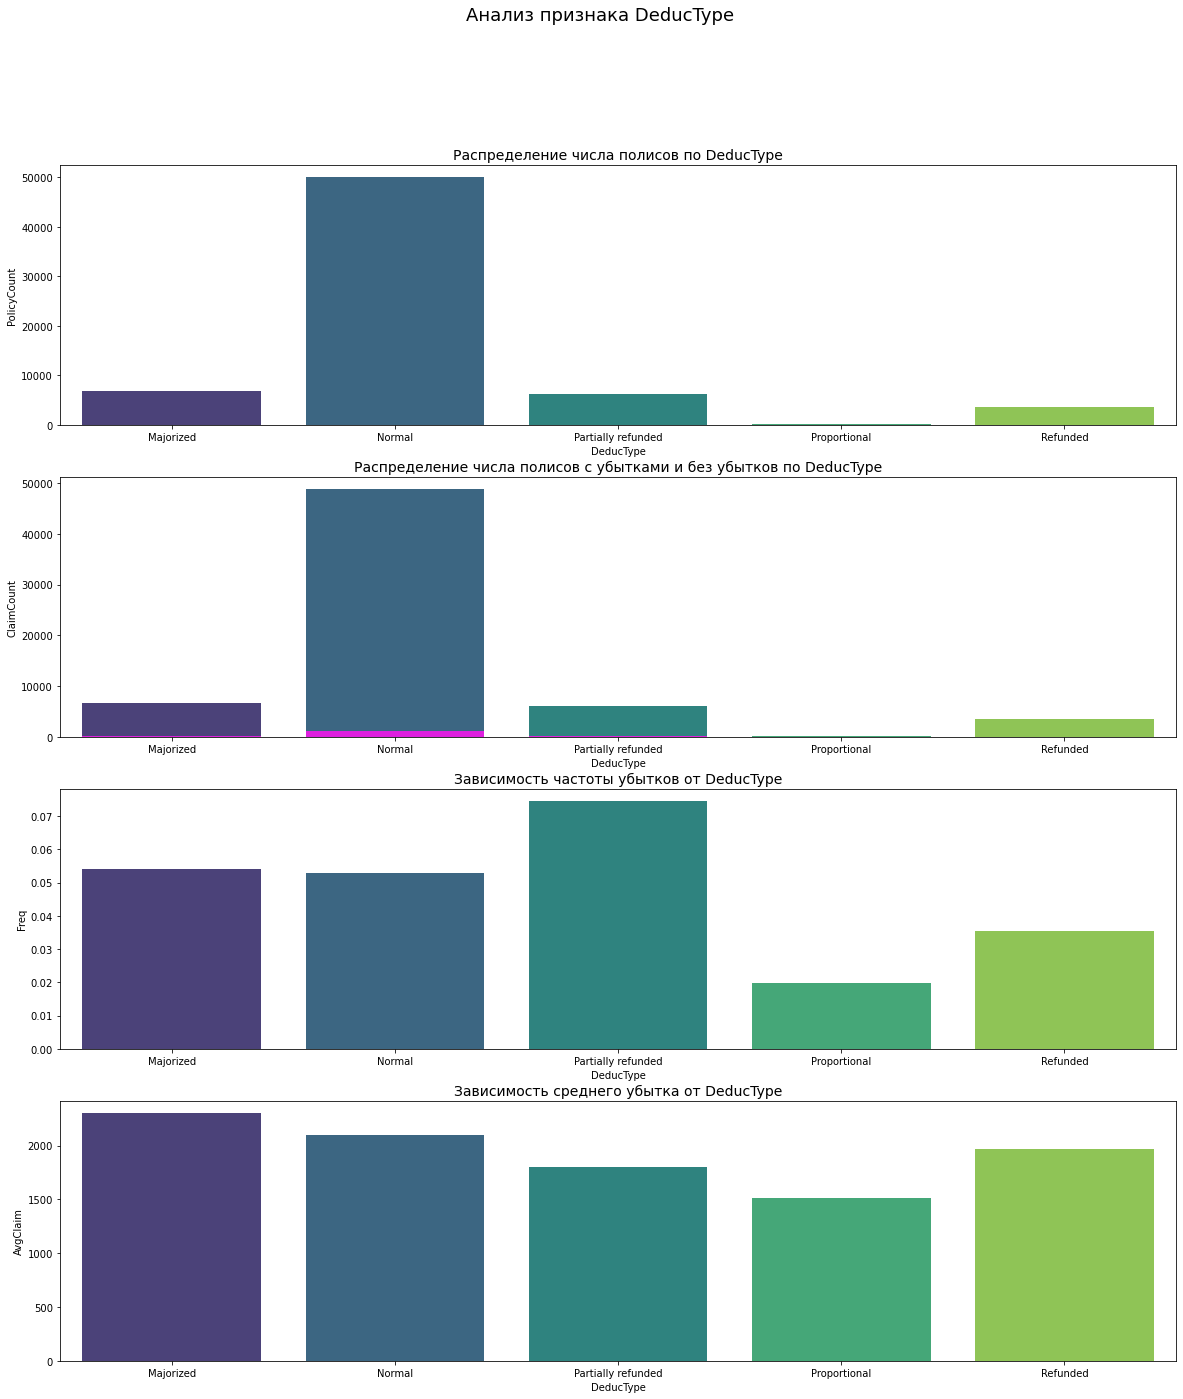

In [25]:
for var_name in CATEGORICAL_FEATURE_NAMES[2:]:
    plot_dependencies(df, var_name)

#### Выводы:
* __VehUsage__ Самое большое число полисов, как и сомое большое число полисов с убытками, сосредоточено в VehUsage=Private+trip to office .Частота убытков растет по мере перехода от личного к профессиональному использлыванию: Private - Private+trip to office - Professional - Professional run. При этом на Professional и особенно Professional run приходится самая на низкая доля полисов. Самый высокий средний убыток - при VehUsage=Professional.
* __VehBody__ Самое большое число полисов выписано на VehBody=sedan, в этой группе сосредоточены основные убытки. Самая высокая частота убытков у VehBody=microvan, van. Cамый высокий средний убыток - при VehBody=microvan.
* __VehPrice__ Основное число полисов, как и полисов с убытками, приходится на VehPrice=D-N (по алфавиту), число полисов в категории VehPrice=Y и Z не материальнно. Можно сказать, что частота убытков нарастает при продвижении VehPrice от A до Z. Самая высокая частота убытков у VehPrice=Y и Z. самый высокий средний убыток - при VehPrice=Z. Но это может быть связано с низким числом наблюдений.
* __VehEngine__  Основное число полисов, как и основное число полисов с убытками, приходится на VehEngine=injection. Самая высокая частота убытков у VehEngine=electric, что может объясняться низким числом полисов в этой группе. Cамый высокий средний убыток - при VehEngine=injection overpowered.
* __VehEnergy__ Самое большое число полисов, как и основное число полисов с убытками, выписано на VehEnergy=regular, на втором месте - VehEnergy=diesel.Самая высокая частота убытков у VehEnergy=electric, но это может быть связано с низким числом наблюдений. Cамый высокий средний убыток - при VehEnergy=diesel.
* __VehMaxSpeed__ Число полисов с убытками распределено более-менее равномерно при VehMaxSpeed больше 130 km/h. Самая низкая частота убытков при VehMaxSpeed=1-130 km/h. При этом, самый высокий средний убыток - тоже при VehMaxSpeed=1-130 km/h
* __VehClass__ Самое большое число полисов выписано на VehClass=B. Самая высокая частота убытков у VehClass=0. Cамый высокий средний убыток - при VehClass=H.
* __Garage__ Большинство полисов, как и полисов с убытками, приходится на Garage=None. При Garage=Private garage частота убытков немного ниже, чем при Garage=None и Collective garage.
* __DeducType__ Большинство полисов, как и полисов с убытками, приходится на DeducType=Normal. Самая высокая частота убытков у DeducType=Partially refunded DeductType. Cамый высокий средний убыток - при DeducType=Majorized.

### 3. Отбор наиболее значимых признаков

#### Обработка категориальных признаков

In [26]:
class FeatureGenerator:
    def __init__(self, CATEGORICAL_FEATURE_NAMES):
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES
        self.NEW_CATEGORICAL_FEATURE_NAMES = []        
        self.target_encodings = dict()       
        
        
    def fit(self, train):
        df = train.copy()
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            new_feature = feature + '_'            
            self.NEW_CATEGORICAL_FEATURE_NAMES.append(new_feature)                        
            self.target_encodings[feature] = {}
            
            for level in df[feature].unique():
                level_value = df.loc[df[feature]==level, TARGET_NAME].mean()
                self.target_encodings[feature][level] = level_value
                
                
    def transform(self, df):
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            for level in self.target_encodings[feature].keys():
                new_feature = feature + '_'                
                df.loc[df[feature] == level, new_feature] = self.target_encodings[feature][level]
        
        return df

In [27]:
TARGET_NAME = 'ClaimInd'

In [28]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(data)
df = features.transform(data)

In [29]:
SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES
SELECTED_FEATURE_NAMES.remove(TARGET_NAME)
SELECTED_FEATURE_NAMES.remove('ClaimAmount')

In [30]:
def select_variables(X, y, k_best=5, percentile=10):
    X = X.fillna(0)
    cols = X.columns
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    y = scaler.fit_transform(np.array(y).reshape(-1, 1))       
    
    f_test, _ = f_regression(X, y)
    f_test /= np.max(f_test)

    # KBest
    sfk = SelectKBest(f_regression, k=k_best)
    sfk.fit_transform(X, y)    
    set_1 = list(cols[sfk.get_support()])

    # Percentile
    sfp = SelectPercentile(f_regression, percentile=percentile)
    sfp.fit_transform(X, y)    
    set_2 = list(cols[sfp.get_support()])

    # Model
    model_cb = CatBoostClassifier(max_depth=5, random_state=40, n_estimators=100, verbose=False,)
    model_cb.fit(X, y.ravel())

    sfm = SelectFromModel(model_cb,  max_features=k_best)
    sfm.fit(X, y.ravel())
    sfm.transform(X)    
    set_3 = list(cols[sfm.get_support()])

    
    return list(set(set_1 + set_2 + set_3))

In [31]:
select_variables(df[SELECTED_FEATURE_NAMES], df[TARGET_NAME])

['Garage_',
 'Dataset',
 'Exposure',
 'RiskArea',
 'VehAge_',
 'VehPrice_',
 'DeducType_',
 'RiskVar']

#### Вывод:
Наиболее значимыми признаками наступления страхового случая являются 
* Garage
* Dataset
* Exposure
* RiskArea
* VehAge
* VehPrice
* DeducType
* RiskVar